## **Effect of Data Scarcity and Class Imbalance on Race/Gender Bias in Profession Classification Models**

* **Author:** Lucas Miralles
* **Date:** Novemver 2025 – January 2026
* **Instructor:** Marcos Escudero

## 1. Introduction

The **performance** and **fairness** of computer vision models strongly depend on the quantity and distribution of training data. In scenarios with limited data or imbalanced classes, models tend to amplify demographic biases.

This project empirically investigates how the combination of **data scarcity** and **class imbalance** affects diferent kind of **bias** (race and gender) in a **profession classification model** based solely on facial images.

## 2. Specific Objectives of the Comparative Analysis

1. Assess the impact of dataset size and class balance on model performance and fairness.

2. Compare multiple training configurations described in section 4.

3. Analyze possible bias (e.g. race, gender) in profession classification.

4. Examine, using **Grad-CAM**, whether attention regions differ across minority groups.

## 3. Theoretical Background

**Learning with Limited Data**

* Scenarios with small or imbalanced datasets
* Effects of sample size on generalization

**Bias in Computer Vision**

* Measurement and mitigation of gender bias
* Importance of fairness in facial recognition models

## 4. Methodology

### Models

* **Base models:** `resnet50`, `MobileNetV2` (pre-trained on *ImageNet*), `fairface_yolo` (pre-trained on *FairFace*)
* **Adapted models:**

  * Fine-tuned on the reduced experiments datasets
*In practice we only used a pretrained resnet50 due to a lack of time*

### Dataset

* We will use the **[FairFace](https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf) dataset:** , annotated with synthetic profession labels

> The “profession” attribute is **not part of the original dataset**; it was **programmatically generated** using a custom `ProfessionLabelGenerator` class. These *pseudo-profession* labels (e.g., *student*, *blue_collar*, *white_collar*, *retired*) were derived from demographic attributes such as **age** and **gender**, following probabilistic rules designed to emulate realistic but **controlled social correlations**.

> This synthetic labeling allows for **systematic bias injection** and **fine-grained control** over the relationships between gender, age, and class distribution. The purpose is **not** to predict real occupations, but to **study how data scarcity and imbalance interact with bias** in classification models under known bias conditions.

* This dataset is preferred over others such as *CelebA* because it is more balanced across race and gender as we can see in the figure extracted from the FarirFace paper:
![comparison](datasets_comparison.png)

### Experimental Dataset Configurations

| Dataset                                                    | Description                                                                                                                        | Focus / Hypothesis                                                                      |
| ---------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- |
| **A – Fully balanced**                                     | Balanced on gender, race, and age; profession natural                                                                              | Baseline fairness and maximum representativeness                                        |
| **B – Gender & profession balanced**                       | Race left natural                                                                                                                  | Race skew may still produce residual bias                                               |
| **C – Race & profession balanced**                         | Gender left natural                                                                                                                | Gender imbalance can still bias profession classification                               |
| **D – Gender & race balanced** | Profession left natural                          | Tests robustness under realistic label imbalance while demographic balance is preserved |

* **Rationale:** This systematic design allows isolation of specific factors (gender imbalance, race imbalance, profession imbalance) to understand their effect on bias amplification in models.


### Evaluation Metrics

* **Performance:** Classification reports (Precision, Recall, F1-Score, Support), Balanced Accuracy
* **Fairness:** Demographic Parity, Equal Opportunity
* **Interpretability:** Visual analysis using Grad-CAM

## 5. Implementation

Download libraries if needed

In [1]:
#!pip install fairlearn
#!pip install grad-cam
#!pip install datasets
#!pip install huggingface_hub[hf_xet]
#...

Import libraries

In [ ]:
import logging
import torch
from datasets import Dataset as HFDataset,load_dataset, concatenate_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import models, transforms
import warnings
import random
import math
import sys
import os

Optionally, ignore warnings

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

General configurations: use GPU/TPU to train deep learning models

In [4]:
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device name:", torch.cuda.get_device_name(0))
    print("Device capability:", torch.cuda.get_device_properties(0))
    DEVICE = torch.device("cuda")
else:
    print("No GPU available — training will be slow.")
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Python: 3.10.11
Torch: 1.13.1+cu117
CUDA available: True
CUDA version: 11.7
Device name: NVIDIA GeForce RTX 3060
Device capability: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12287MB, multi_processor_count=28)
Using device: cuda


Optionally, reproducibility configuration to obtain the same results as in this notebook

In [6]:
def set_seed(seed: int) -> None:
    """
    Set random seeds for reproducibility across Python, NumPy, and PyTorch.

    Parameters:
        seed (int): Random seed value.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensures deterministic behavior in PyTorch (may slightly affect performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 33
set_seed(SEED)
print(f"Random seed set to {SEED}")

Random seed set to 33


### 5.1 FairFace Dataset Setup

The **FairFace dataset** contains over 100,000 face images labeled by:

* **Race** (7 racial groups)
* **Gender** (male / female)
* **Age** (age range categories)

We will use the **official FairFace dataset** hosted on **Hugging Face**, and specifically load the **reduced 25% version** (`"0.25"`) to keep resource usage reasonable in Colab.


[Official mapping dictionaries](https://huggingface.co/datasets/HuggingFaceM4/FairFace)

In [7]:
race_mapping = {
    0: "East Asian",
    1: "Indian",
    2: "Black",
    3: "White",
    4: "Middle Eastern",
    5: "Latino_Hispanic",
    6: "Southeast Asian"
}

gender_mapping = {
    0: "Male",
    1: "Female"
}

age_mapping = {
    0: "0-2",
    1: "3-9",
    2: "10-19",
    3: "20-29",
    4: "30-39",
    5: "40-49",
    6: "50-59",
    7: "60-69",
    8: "70+"
}

service_mapping = {
    False: "No",
    True: "Yes"
}

Loading the dataset

In [8]:
# Load the FairFace dataset (reduced 25% version)
dataset = load_dataset("HuggingFaceM4/FairFace", "0.25")

# Display dataset splits
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})


Define and apply mapping functions in order to visualize. We would use ```_str``` to each attribute to indicate his string version

In [9]:
# Define mapping functions
def map_race(example):
    example["race_str"] = race_mapping[example["race"]]
    return example

def map_gender(example):
    example["gender_str"] = gender_mapping[example["gender"]]
    return example

def map_age(example):
    example["age_str"] = age_mapping[example["age"]]
    return example

def map_service(example):
    example["service_test_str"] = service_mapping[example["service_test"]]
    return example

# Apply mappings without converting to pandas
dataset["train"], dataset["validation"] = dataset["train"].map(map_race), dataset["validation"].map(map_race)
dataset["train"], dataset["validation"] = dataset["train"].map(map_gender), dataset["validation"].map(map_gender)
dataset["train"], dataset["validation"] = dataset["train"].map(map_age), dataset["validation"].map(map_age)
dataset["train"], dataset["validation"] = dataset["train"].map(map_service), dataset["validation"].map(map_service)

Visualize Sample Images to get familiar with the data

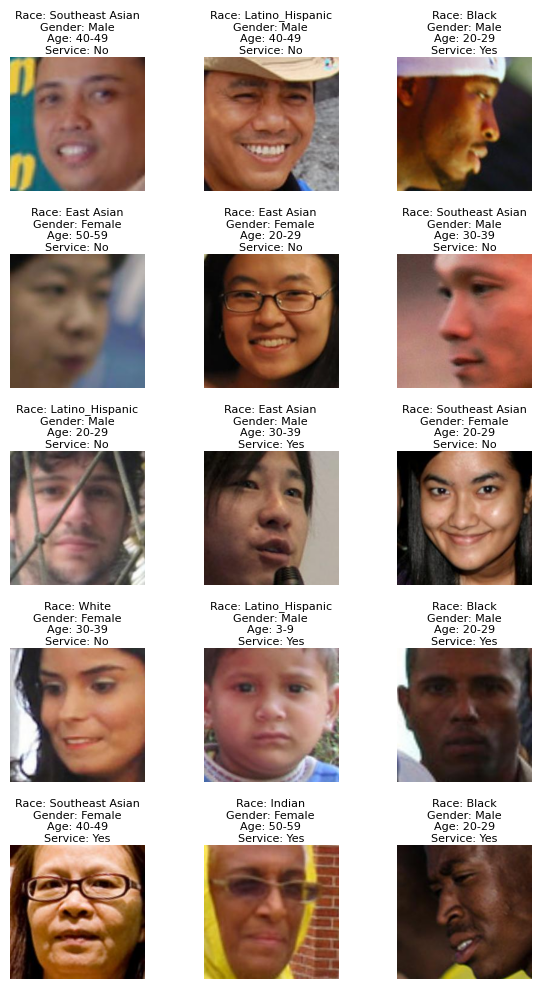

In [10]:
def show_samples(dataset, n=6):
    # Determine grid size
    cols = min(n, 3)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Shuffle once and select samples
    samples = dataset.shuffle(seed=SEED).select(range(n))

    for i, ax in enumerate(axes):
        if i >= n:
            ax.axis("off")
            continue

        example = samples[i]
        img = example["image"]

        # Properly aligned multiline label
        label = "\n".join([
            f"Race: {example['race_str']}",
            f"Gender: {example['gender_str']}",
            f"Age: {example['age_str']}",
            f"Service: {example['service_test_str']}"
        ])

        ax.imshow(img)
        ax.set_title(label, fontsize=8, pad=3, loc='center')
        ax.axis("off")

        # Add border for clarity
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

# Display 6 sample images
show_samples(dataset["train"], n=15)

**Inspecting Labels and Distribution in FairFace**

Race counts/proportions:
- White: 18612 (19.1%)
- Latino_Hispanic: 14990 (15.3%)
- East Asian: 13837 (14.2%)
- Indian: 13835 (14.2%)
- Black: 13789 (14.1%)
- Southeast Asian: 12210 (12.5%)
- Middle Eastern: 10425 (10.7%)


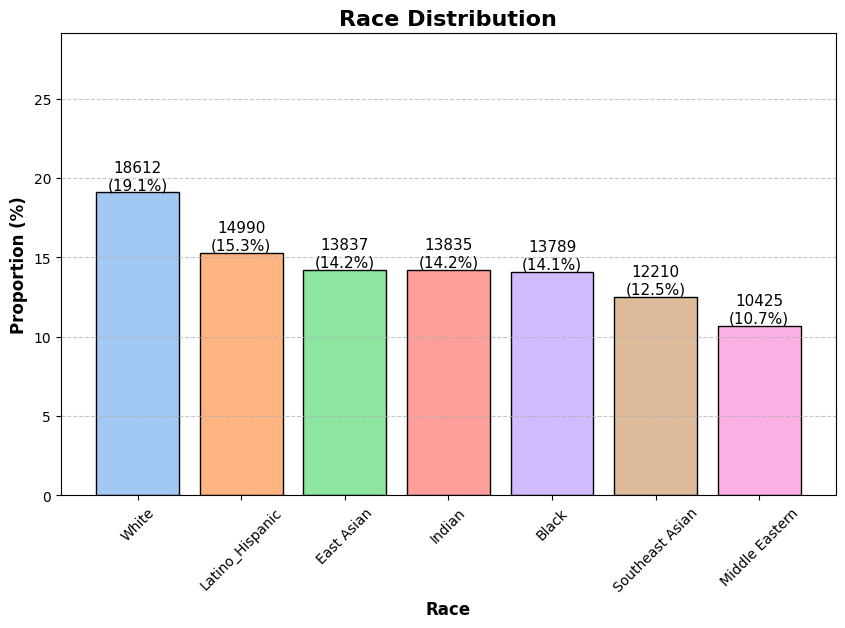

Gender counts/proportions:
- Male: 51778 (53.0%)
- Female: 45920 (47.0%)


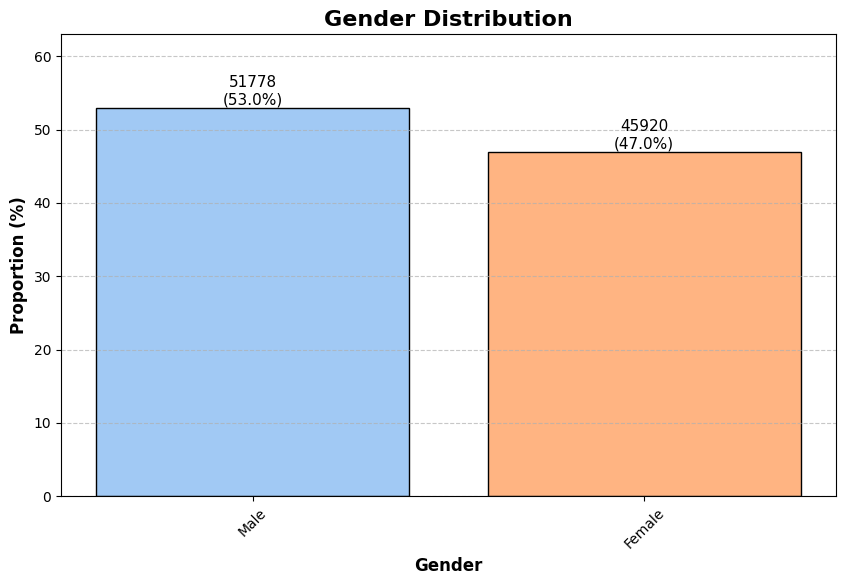

Age counts/proportions:
- 20-29: 28898 (29.6%)
- 30-39: 21580 (22.1%)
- 40-49: 12097 (12.4%)
- 3-9: 11764 (12.0%)
- 10-19: 10284 (10.5%)
- 50-59: 7024 (7.2%)
- 60-69: 3100 (3.2%)
- 0-2: 1991 (2.0%)
- 70+: 960 (1.0%)


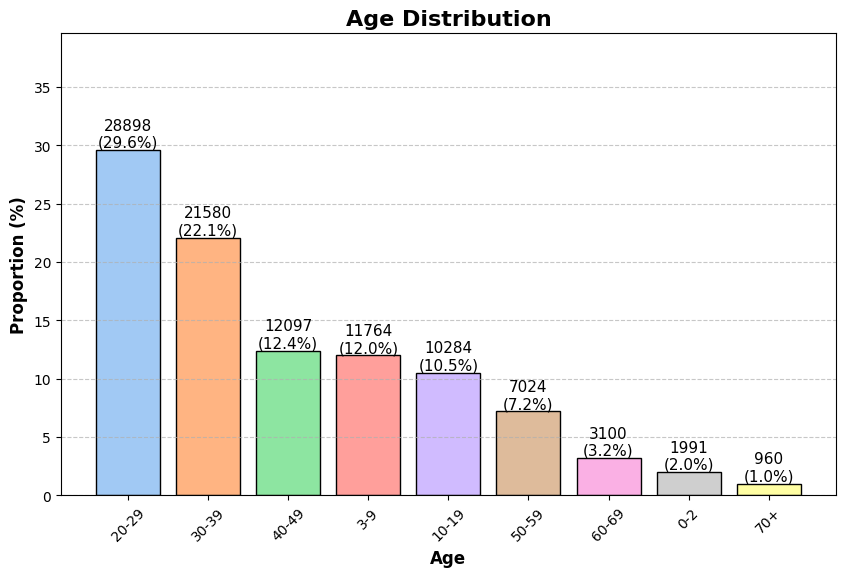

Service_test counts/proportions:
- No: 52284 (53.5%)
- Yes: 45414 (46.5%)


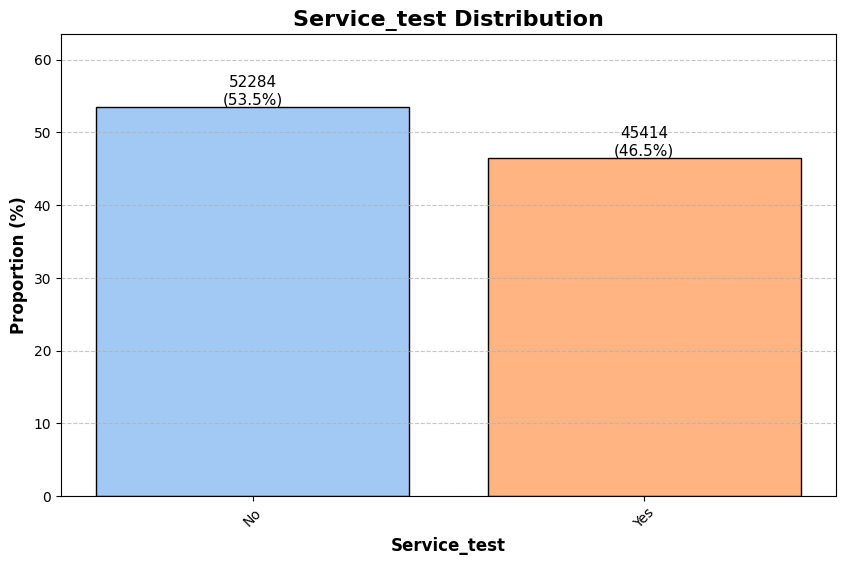

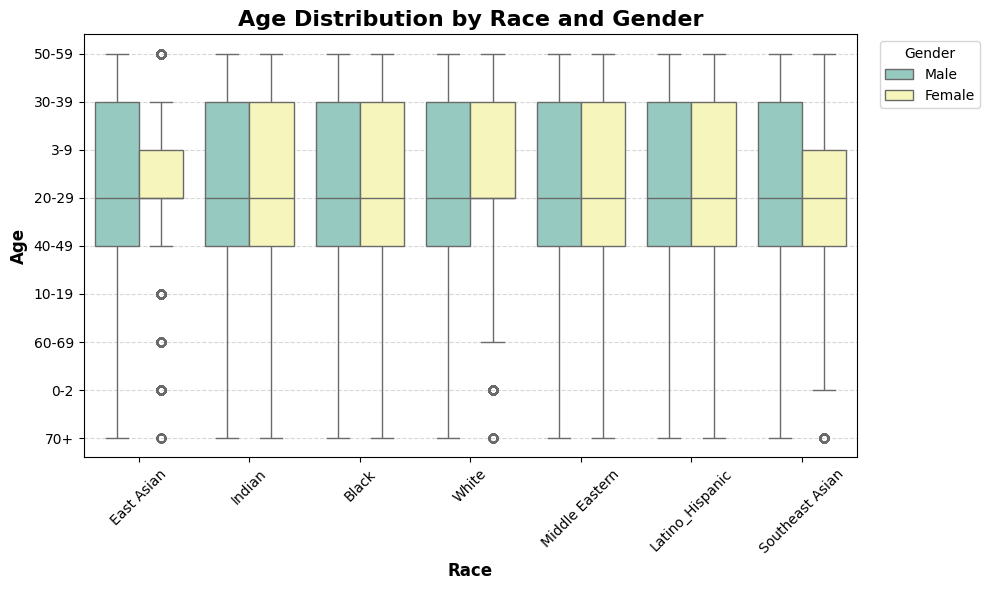

In [11]:
# Combine train + validation and convert to DataFrame
full_dataset = concatenate_datasets([dataset["train"], dataset["validation"]])

# List of columns to keep (exclude 'image')
columns_to_keep = [c for c in full_dataset.column_names if c != "image"]

# Convert only these columns to a pandas DataFrame
full_df = pd.DataFrame({c: full_dataset[c] for c in columns_to_keep})

# Quick check
cols_to_drop = ["age", "gender", "race", "service_test"]
full_df.drop(columns=cols_to_drop, inplace=True)

full_df.rename(columns=lambda c: c.replace("_str", ""), inplace=True)

# Function to compute counts and proportions
def get_distribution_df(df, column):
    counts = df[column].value_counts()
    props = (counts / counts.sum() * 100).round(1)
    return counts, props

# Function to plot bar charts
def plot_count_with_pct_df(df, column, title=None, palette="pastel"):
    counts, props = get_distribution_df(df, column)

    plt.figure(figsize=(10,6))
    colors = sns.color_palette(palette, len(counts))
    bars = plt.bar(counts.index, props, color=colors, edgecolor='black')

    for bar, k in zip(bars, counts.index):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                 f"{counts[k]}\n({props[k]:.1f}%)",
                 ha='center', va='bottom', fontsize=11)

    if title is None:
        title = f"{column.capitalize()} Distribution"

    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel("Proportion (%)", fontsize=12, fontweight='heavy')
    plt.xlabel(column.capitalize(), fontsize=12, fontweight='heavy')
    plt.ylim(0, max(props)+10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()

# Display distributions for categorical columns
categorical_columns = ["race", "gender", "age", "service_test"]

for col in categorical_columns:
    counts, props = get_distribution_df(full_df, col)
    print(f"{col.capitalize()} counts/proportions:")
    for k in counts.index:
        print(f"- {k}: {counts[k]} ({props[k]:.1f}%)")
    plot_count_with_pct_df(full_df, col, title=f"{col.capitalize()} Distribution")

# Plot age by race and gender (box plot)
plt.figure(figsize=(10,6))
sns.boxplot(
    data=full_df,
    x="race",
    y="age",
    hue="gender",
    palette="Set3"
)
plt.title("Age Distribution by Race and Gender", fontsize=16, fontweight='bold')
plt.ylabel("Age", fontsize=12, fontweight='heavy')
plt.xlabel("Race", fontsize=12, fontweight='heavy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Gender', loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

### 5.2 Observations on Dataset Imbalance

From the distributions of the **FairFace** dataset, we can observe a few mild imbalances. However, these are significantly less severe than those found in widely used alternatives as we saw.

**Race**

* The dataset contains more samples of **White (19.1%)** and **Latino/Hispanic (15.3%)** individuals.
* Groups such as **Middle Eastern (10.7%)** and **Southeast Asian (12.5%)** are slightly underrepresented.
* Overall, racial representation is relatively well-distributed, making *FairFace* one of the most balanced datasets for fairness studies.

**Gender**

* Slight predominance of **Male (53.0%)** over **Female (47.0%)** samples.
* This near parity indicates a good gender balance compared to many facial datasets, which often exhibit stronger bias toward one gender.

**Age**

* Most samples fall within the **20–29 (29.6%)** and **30–39 (22.1%)** ranges.
* Representation drops for younger and older ages:

  * **0–2 (2.0%)**, **60–69 (3.2%)**, and **70+ (1.0%)** are notably underrepresented.
* This skew may reduce model accuracy for very young and elderly individuals.

**Service Test**

* The *service_test* label (indicating dataset partition or domain source) is **approximately balanced**:

  * **No: 53.5%**, **Yes: 46.5%**.
* Since this attribute does not represent a demographic feature, it is not a direct source of social bias.

#### **Implications**

* While *FairFace* remains **more balanced** than most facial datasets, subtle skews exist across **race** and **age**.
* These disparities could still lead to **slightly better model performance** for majority classes.
* Applying **data augmentation**, **class weighting**, or **resampling** strategies can further mitigate these residual imbalances.

### 5.3 Assigning Pseudo-Professions in FairFace

To study gender bias in profession classification, we **generate synthetic profession labels** using the `ProfessionLabelGenerator` class. These labels are **not real occupations**, but are designed to emulate realistic distributions based on age, gender, and race.


* **Purpose:** Assign probabilistic professions (`student`, `blue_collar`, `white_collar`, `retired`) based on demographic attributes.

* **Bias modes:**

  * `None` → no bias (baseline)
  * `"gender"` → reduces white-collar likelihood for females
  * `"race"` → reduces white-collar likelihood for selected racial groups
  * `"intersectional"` → combines gender + race + optional age-specific adjustments

* **Key Features:**

  * Generates labels reproducibly with `seed`.
  * Supports **vectorized mapping** to Hugging Face datasets.
  * Can smooth probabilities for realistic variability.

#### Probabilistic Assignment by Age

| Age Range | Student | Blue Collar | White Collar | Retired |
| --------- | ------- | ----------- | ------------ | ------- |
| 0–2       | 0.90    | 0.05        | 0.03         | 0.02    |
| 3–9       | 0.95    | 0.02        | 0.02         | 0.01    |
| 10–19     | 0.85    | 0.05        | 0.08         | 0.02    |
| 20–29     | 0.15    | 0.35        | 0.45         | 0.05    |
| 30–39     | 0.05    | 0.30        | 0.60         | 0.05    |
| 40–49     | 0.02    | 0.30        | 0.63         | 0.05    |
| 50–59     | 0.01    | 0.35        | 0.55         | 0.09    |
| 60–69     | 0.01    | 0.25        | 0.40         | 0.34    |
| 70+       | 0.00    | 0.10        | 0.15         | 0.75    |

These distributions simulate realistic career stages and allow controlled experimentation with class imbalance.

In [12]:
class ProfessionLabelGenerator:
    """
    Generate pseudo-profession labels based on age and gender,
    with optional bias injection.
    Compatible with Hugging Face Datasets.
    """

    def __init__(self, seed=42, smooth=True):
        self.seed = seed
        np.random.seed(seed)
        self.smooth = smooth

        # Base probabilities of professions by age range
        # Each value is a dict with probabilities that sum to 1
        self.age_profession_probs = {
            "0-2":  {"student": 0.9, "blue_collar": 0.05, "white_collar": 0.03, "retired": 0.02},
            "3-9":  {"student": 0.95, "blue_collar": 0.02, "white_collar": 0.02, "retired": 0.01},
            "10-19": {"student": 0.85, "blue_collar": 0.05, "white_collar": 0.08, "retired": 0.02},
            "20-29": {"student": 0.15, "blue_collar": 0.35, "white_collar": 0.45, "retired": 0.05},
            "30-39": {"student": 0.05, "blue_collar": 0.3, "white_collar": 0.6,  "retired": 0.05},
            "40-49": {"student": 0.02, "blue_collar": 0.3, "white_collar": 0.63, "retired": 0.05},
            "50-59": {"student": 0.01, "blue_collar": 0.35, "white_collar": 0.55, "retired": 0.09},
            "60-69": {"student": 0.01, "blue_collar": 0.25, "white_collar": 0.4,  "retired": 0.34},
            "70+":   {"student": 0.0,  "blue_collar": 0.1,  "white_collar": 0.15, "retired": 0.75}
        }

    def assign_profession(self, example, bias_mode=None, bias_strength=0.15):
        import numpy as np  # Important inside worker
        
        probs = self.age_profession_probs.get(example["age_str"], None)
        if probs is None:
            return "unknown"

        biased_probs = probs.copy()
        
        if bias_mode == "gender":
            if example["gender_str"] == "Female":
                biased_probs["white_collar"] *= (1 - bias_strength)
                biased_probs["blue_collar"]  *= (1 + bias_strength / 2)
        elif bias_mode == "race":
            if example["race_str"] in ["Black", "Latino_Hispanic"]:
                biased_probs["white_collar"] *= (1 - bias_strength)
                biased_probs["blue_collar"]  *= (1 + bias_strength)
        elif bias_mode == "intersectional":
            # Combine gender + race + age biases
            if example["gender_str"] == "Female":
                biased_probs["white_collar"] *= (1 - bias_strength)
                biased_probs["blue_collar"]  *= (1 + bias_strength / 2)
            if example["race_str"] in ["Black", "Latino_Hispanic"]:
                biased_probs["white_collar"] *= (1 - bias_strength/2)
                biased_probs["blue_collar"]  *= (1 + bias_strength/2)
            # Age-specific tweaks (optional)
            if example["age_str"] in ["20-29", "30-39"] and example["gender_str"] == "Female":
                biased_probs["white_collar"] *= (1 - bias_strength/3)

        # Normalize probabilities
        total = sum(biased_probs.values())
        probs = {k: v/total for k, v in biased_probs.items()}

        labels = list(probs.keys())
        values = list(probs.values())
        return np.random.choice(labels, p=values)


    def generate_labels(self, ds: HFDataset, bias_mode=None, bias_strength=0.15, new_column="profession", num_proc=1):
        """
        Efficiently apply label generation to a Hugging Face dataset.
        """
        def _map_fn(example):
            import numpy as np  # Important inside worker
            example[new_column] = self.assign_profession(example, bias_mode, bias_strength)
            return example

        return ds.map(_map_fn, num_proc=num_proc)


To simulate realistic pseudo-profession labels while controlling for experimental conditions, we define a workflow combining:

1. **ProfessionLabelGenerator** – assigns probabilistic professions based on age, gender, and race.
2. **Stratified subset creation** – balances the dataset along chosen axes (`race`, `gender`, `profession`, `age`).
3. **Bias injection** – optional reduction of females in specific professions to simulate gender bias.


In [13]:
def _ds_to_df(ds_or_df: (HFDataset |pd.DataFrame)):
    """Converts datasets.Dataset to a pandas.DataFrame if needed for visualization."""
    if isinstance(ds_or_df, HFDataset):
        return ds_or_df.to_pandas()
    elif isinstance(ds_or_df, pd.DataFrame):
        return ds_or_df
    else:
        raise ValueError("Se esperaba datasets.Dataset o pandas.DataFrame")

In [14]:
def summarize_dataset(ds_or_df: (HFDataset |pd.DataFrame), name):
    df = _ds_to_df(ds_or_df)
    print(f"\n=== {name} ===")
    print(f"Total count: {len(df)}")
    print("\nDistribution by gender, race, and profession:")
    print(df.groupby(["gender_str","race_str","profession"]).size())
    print("\nGender distribution:")
    print(df["gender_str"].value_counts(normalize=True))
    print("\nAge distribution:")
    print(df["age_str"].value_counts(normalize=True))
    print("\nProfession distribution:")
    print(df["profession"].value_counts(normalize=True))
    
def plot_distribution(ds_or_df: (HFDataset |pd.DataFrame), column: str, title: str = None,
                      hue: str = "gender_str", palette: str = "pastel") -> None:
    """
    Plot the distribution of a categorical column separated by a hue factor,
    with count and percentage annotations above each bar.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset.
    column : str
        Name of the categorical column to plot.
    title : str, optional
        Custom title. If None, a default is generated.
    hue : str, optional
        Column used to color the bars (default: 'gender_str').
    palette : str, optional
        Seaborn color palette (default: 'pastel').
    """
    df = _ds_to_df(ds_or_df)
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x=column, hue=hue, palette=palette, edgecolor='black')

    total = len(df)
    max_height = 0

    # Annotate bars
    for p in ax.patches:
        height = p.get_height()
        if height == 0:
            continue
        percentage = 100 * height / total
        x = p.get_x() + p.get_width() / 2
        y = height
        ax.text(x, y, f"{int(height)}\n({percentage:.1f}%)",
                ha='center', va='bottom', fontsize=10)
        max_height = max(max_height, height)

    # Add some headroom above the tallest bar
    ax.set_ylim(0, max_height * 1.15)

    # Title and labels
    if title is None:
        title = f"{column.capitalize()} distribution"
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel(column.capitalize(), fontsize=12, fontweight='heavy')
    ax.set_ylabel("Count", fontsize=12, fontweight='heavy')

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [15]:
generator = ProfessionLabelGenerator(seed=SEED)

# Combine splits
train_ds = dataset["train"]
valid_ds = dataset["validation"]

# Generate labels
train_ds = generator.generate_labels(train_ds, bias_mode=None, new_column="profession", num_proc=1)
valid_ds = generator.generate_labels(valid_ds, bias_mode=None, new_column="profession", num_proc=1)

train_df = train_ds.to_pandas()
valid_df = valid_ds.to_pandas()


=== Original Train ===
Total count: 86744

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar     1465
                             retired          333
                             student         1972
                             white_collar    2367
            East Asian       blue_collar     1611
                             retired          317
                             student         1825
                             white_collar    2388
            Indian           blue_collar     1408
                             retired          408
                             student         1832
                             white_collar    2261
            Latino_Hispanic  blue_collar     1633
                             retired          395
                             student         2067
                             white_collar    2620
            Middle Eastern   blue_collar      769
                  

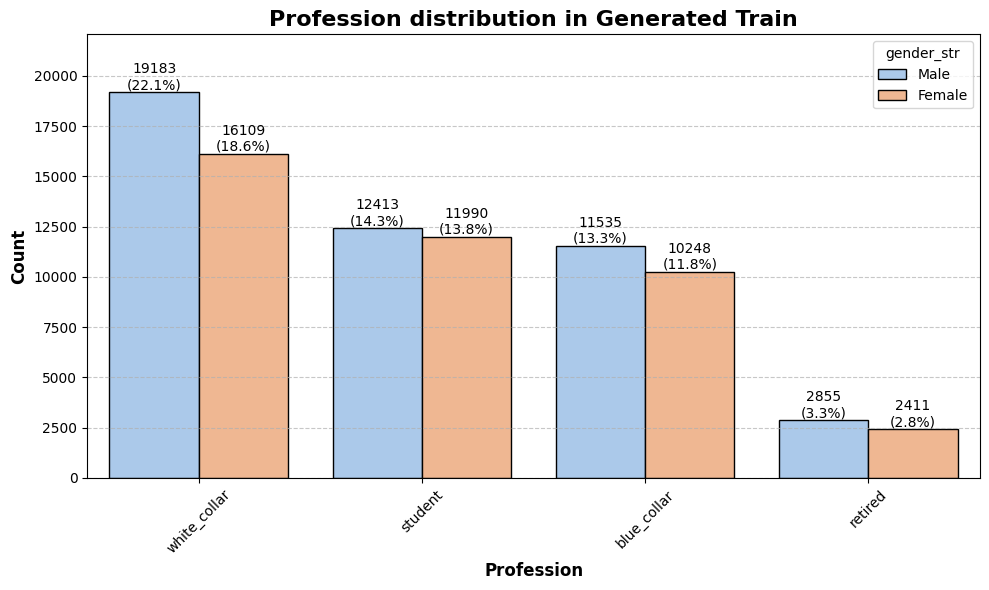


=== Original Valid ===
Total count: 10954

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar     159
                             retired          43
                             student         258
                             white_collar    297
            East Asian       blue_collar     205
                             retired          41
                             student         229
                             white_collar    298
            Indian           blue_collar     193
                             retired          43
                             student         241
                             white_collar    286
            Latino_Hispanic  blue_collar     217
                             retired          46
                             student         242
                             white_collar    325
            Middle Eastern   blue_collar      99
                             retire

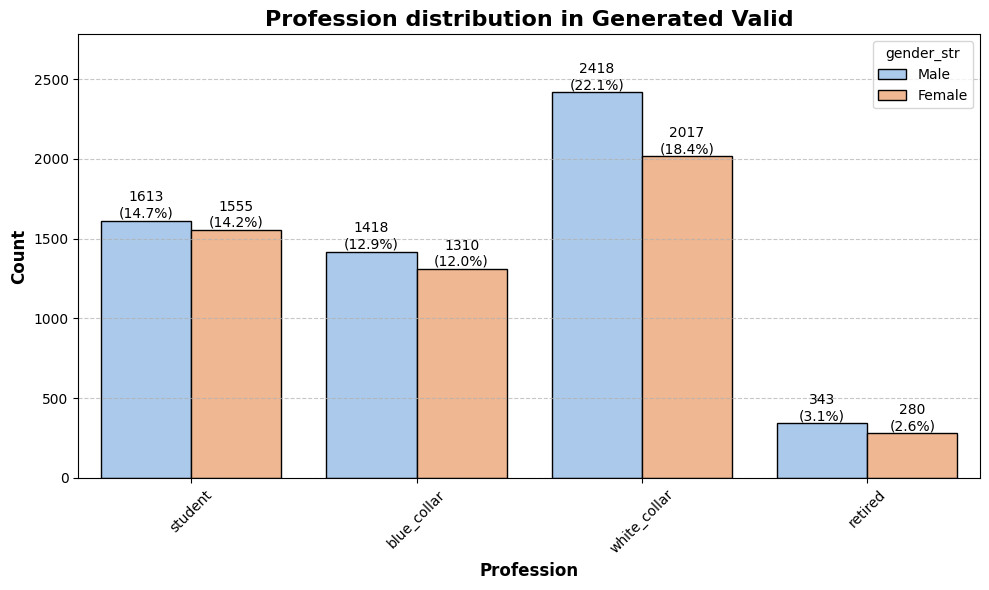

In [16]:
summarize_dataset(train_df, "Original Train")
plot_distribution(train_df, "profession", f"Profession distribution in Generated Train")

summarize_dataset(valid_df, "Original Valid")
plot_distribution(valid_df, "profession", f"Profession distribution in Generated Valid")

**Observations**

The introduction of pseudo-profession labels results in a dataset that is **intentionally non-uniform and demographically structured**, reflecting realistic correlations between age, gender, race, and occupational outcomes rather than enforcing artificial balance.

Several key observations can be made:

1. **Age-driven structure dominates profession assignment.**
   As designed, profession distributions closely follow plausible life-course patterns: younger age groups are overwhelmingly assigned to *student*, middle-aged groups concentrate in *white-collar* and *blue-collar* categories, and older groups progressively shift toward *retired*. This confirms that the generator preserves a strong, interpretable age–profession dependency.

2. **Gender and race disparities emerge naturally and via controlled bias injection.**
   Even in the absence of explicit bias modes, slight imbalances across gender and race appear due to the interaction between age distributions and base probabilities. When bias modes are enabled, these disparities become more pronounced in a controlled and traceable manner, particularly in *white-collar* representation for selected gender and racial groups.

3. **Consistency across train and validation splits.**
   The distributions of gender, age, race, and profession remain highly consistent between training and validation sets, indicating that the stratified sampling and label generation procedures preserve demographic structure without introducing split-specific artifacts.

4. **Class imbalance is preserved rather than corrected.**
   The resulting profession distribution (dominance of *white-collar*, followed by *student* and *blue-collar*, with *retired* as a minority class) mirrors real-world occupational prevalence. This choice intentionally avoids class rebalancing, allowing fairness metrics to be evaluated under realistic imbalance conditions.

5. **Synthetic bias with known ground truth.**
   Importantly, the profession labels do not represent real occupations but **synthetic constructs with explicitly defined bias mechanisms**. This provides a rare experimental advantage: observed unfairness can be directly attributed to known bias injections rather than latent or unobservable societal factors.

#### Generalized Subset Creation

In [17]:
# -----------------------------
# 1. Helper: Identify shared group combinations between train and valid
# -----------------------------
def get_common_groups(train_ds: HFDataset, valid_ds: HFDataset, balance_cols):
    """
    Find all (balance_cols) combinations present in both train and valid.
    Returns a DataFrame with the minimum available count per group.
    """
    train_df = train_ds.to_pandas()
    valid_df = valid_ds.to_pandas()

    train_counts = train_df.groupby(balance_cols).size()
    valid_counts = valid_df.groupby(balance_cols).size()

    common = pd.concat([train_counts, valid_counts], axis=1, keys=["train", "valid"]).dropna()
    common["max_n"] = common.min(axis=1).astype(int)
    return common[["max_n"]]


# -----------------------------
# 2. Helper: Create matched subsets for train and valid
# -----------------------------
def create_matched_subsets(train_ds: HFDataset, valid_ds: HFDataset, balance_cols, max_per_group=None, seed=SEED):
    """
    Create train/valid subsets with identical group structure and counts.
    Only subsampling is used (no oversampling).
    """
    train_df = train_ds.to_pandas()
    valid_df = valid_ds.to_pandas()

    common = get_common_groups(train_ds, valid_ds, balance_cols)

    train_indices = []
    valid_indices = []

    for keys, row in common.iterrows():
        n_take = int(row["max_n"])
        if max_per_group:
            n_take = min(n_take, max_per_group)

        # Construir máscaras sobre dataframes y muestrear índices originales
        mask_train = np.ones(len(train_df), dtype=bool)
        mask_valid = np.ones(len(valid_df), dtype=bool)
        for col, val in zip(balance_cols, keys):
            mask_train &= train_df[col] == val
            mask_valid &= valid_df[col] == val

        group_train = train_df[mask_train]
        group_valid = valid_df[mask_valid]

        if len(group_train) >= n_take and len(group_valid) >= n_take and n_take > 0:
            sampled_train_idx = group_train.sample(n=n_take, random_state=seed).index.tolist()
            sampled_valid_idx = group_valid.sample(n=n_take, random_state=seed).index.tolist()
            train_indices.extend(sampled_train_idx)
            valid_indices.extend(sampled_valid_idx)

    # Shuffle indices reproduciblemente
    rng = np.random.RandomState(seed)
    rng.shuffle(train_indices)
    rng.shuffle(valid_indices)

    # Seleccionar sobre HF Dataset (manteniendo tipo datasets.Dataset)
    train_subset_ds = train_ds.select(train_indices)
    valid_subset_ds = valid_ds.select(valid_indices)

    return train_subset_ds, valid_subset_ds


# -----------------------------
# 3. Helper: Inject gender bias into a specific profession
# -----------------------------
def inject_gender_bias(ds: HFDataset, target_profession="white_collar", female_fraction=0.1, seed=SEED):
    """
    Artificially inject gender imbalance by reducing the number of females
    in the target profession.
    """
    df = ds.to_pandas()
    male_df = df[(df["gender_str"] == "Male") & (df["profession"] == target_profession)]
    female_df = df[(df["gender_str"] == "Female") & (df["profession"] == target_profession)]
    other_df = df[df["profession"] != target_profession]

    n_female_keep = int(len(female_df) * female_fraction)
    if n_female_keep > 0:
        female_df = female_df.sample(n=n_female_keep, random_state=seed)
    else:
        female_df = pd.DataFrame(columns=df.columns)

    biased_df = pd.concat([male_df, female_df, other_df])
    biased_df = biased_df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Convert back to HF Dataset
    return HFDataset.from_pandas(biased_df, preserve_index=False)

In [18]:
def create_stratified_subset(ds: HFDataset,
                             n_per_group: int = None,
                             balance_cols: list = ["gender_str", "race_str", "profession"],
                             seed: int = SEED) -> HFDataset:
    """
    Create a stratified subset by sampling an equal number of samples per unique combination
    of the specified balancing columns.

    Parameters
    ----------
    ds : dataset.Dataset
        Input dataset.
    n_per_group : int, optional
        Number of samples per unique group combination. If None, use the minimum available.
    balance_cols : list of str
        Columns to balance across (default: ['gender_str', 'race_str', 'profession']).
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    dataset.Dataset
        Stratified subset dataset.Dataset.
    """
    df = ds.to_pandas()
    grouped = df.groupby(balance_cols)

    if n_per_group is None:
        n_per_group = grouped.size().min()

    selected_indices = []
    for _, group in grouped:
        take = min(len(group), n_per_group)
        sampled = group.sample(n=take, random_state=seed)
        selected_indices.extend(sampled.index.tolist())

    rng = np.random.RandomState(seed)
    rng.shuffle(selected_indices)

    return ds.select(selected_indices)

def create_stratified_pair(train_ds: HFDataset, valid_ds: HFDataset, **kwargs):
    return (
        create_stratified_subset(train_ds, **kwargs),
        create_stratified_subset(valid_ds, **kwargs)
    )


#### Datasets creation

In [19]:
# Create datasets with consistent sizes. n_per_group is an hyperparameter
datasets_dict = {}

# Dataset A: Fully balanced (race, gender, profession)
datasets_dict["A_train"], datasets_dict["A_valid"] = create_stratified_pair(
    train_ds, valid_ds, balance_cols=["race_str", "gender_str", "profession"], seed=SEED
)

# Dataset B: Balanced by gender and profession, race natural
datasets_dict["B_train"], datasets_dict["B_valid"] = create_stratified_pair(
    train_ds, valid_ds, balance_cols=["gender_str", "profession"], seed=SEED
)

# Dataset C: Balanced by race and profession, gender natural
datasets_dict["C_train"], datasets_dict["C_valid"] = create_stratified_pair(
    train_ds, valid_ds, balance_cols=["race_str", "profession"], seed=SEED
)

# Dataset D: Balanced by race and gender, profession natural
datasets_dict["D_train"], datasets_dict["D_valid"] = create_stratified_pair(
    train_ds, valid_ds, balance_cols=["race_str", "gender_str"], seed=SEED
)

# ... Further datasets can be created as needed to explore different bias scenarios

#### Summary & Plotting


=== A_train ===
Total count: 9128

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar     163
                             retired         163
                             student         163
                             white_collar    163
            East Asian       blue_collar     163
                             retired         163
                             student         163
                             white_collar    163
            Indian           blue_collar     163
                             retired         163
                             student         163
                             white_collar    163
            Latino_Hispanic  blue_collar     163
                             retired         163
                             student         163
                             white_collar    163
            Middle Eastern   blue_collar     163
                             retired       

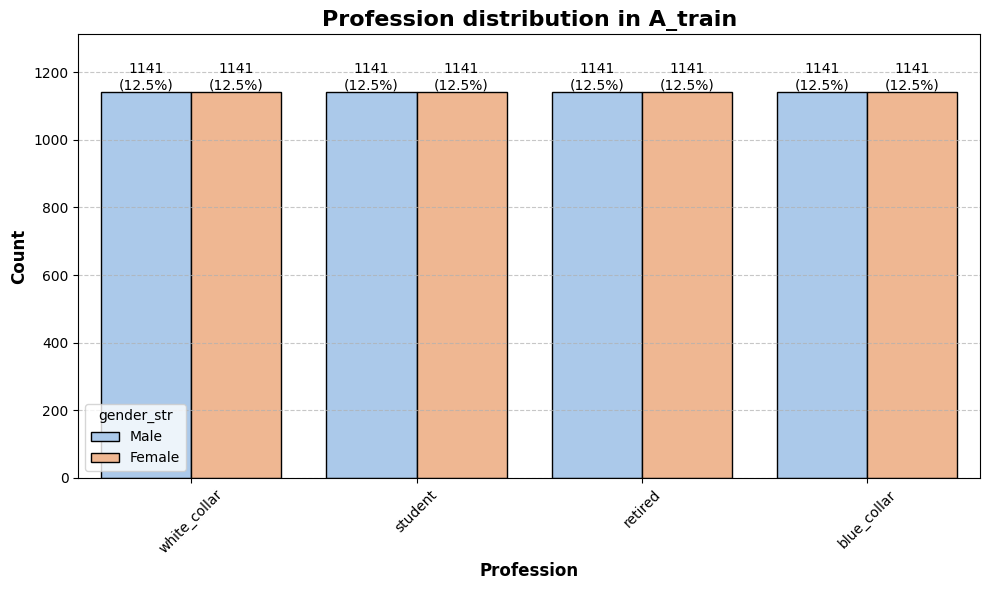


=== A_valid ===
Total count: 896

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar     16
                             retired         16
                             student         16
                             white_collar    16
            East Asian       blue_collar     16
                             retired         16
                             student         16
                             white_collar    16
            Indian           blue_collar     16
                             retired         16
                             student         16
                             white_collar    16
            Latino_Hispanic  blue_collar     16
                             retired         16
                             student         16
                             white_collar    16
            Middle Eastern   blue_collar     16
                             retired         16
             

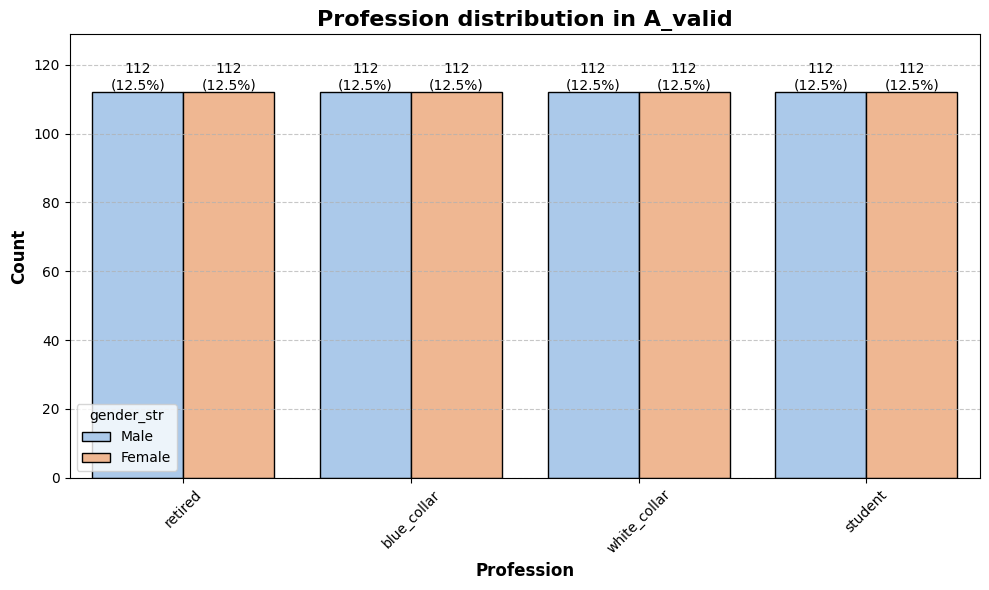


=== B_train ===
Total count: 19288

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar     318
                             retired         333
                             student         352
                             white_collar    348
            East Asian       blue_collar     403
                             retired         317
                             student         363
                             white_collar    365
            Indian           blue_collar     339
                             retired         408
                             student         395
                             white_collar    338
            Latino_Hispanic  blue_collar     392
                             retired         395
                             student         410
                             white_collar    405
            Middle Eastern   blue_collar     171
                             retired      

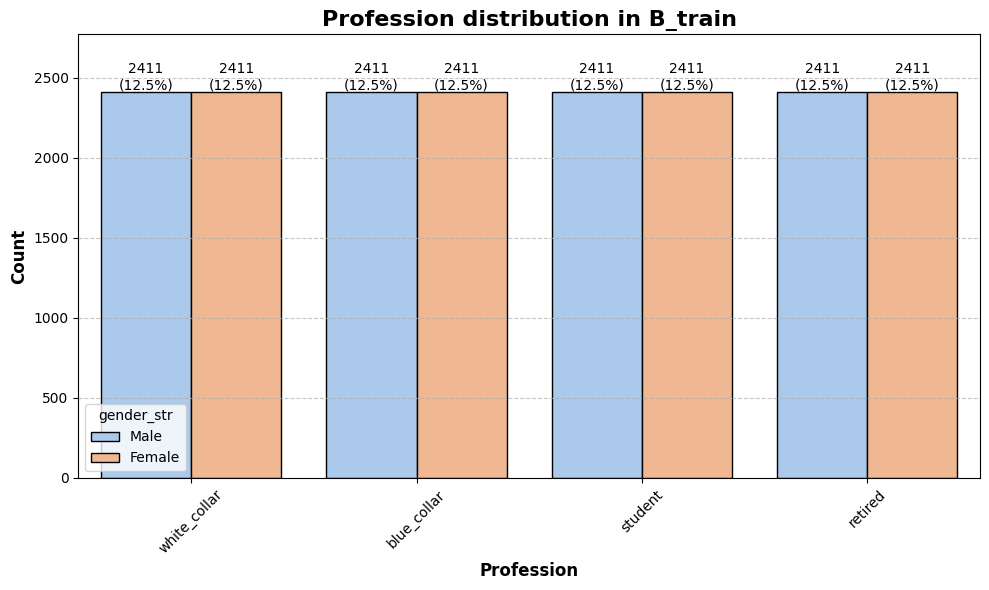


=== B_valid ===
Total count: 2240

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar     27
                             retired         43
                             student         45
                             white_collar    46
            East Asian       blue_collar     47
                             retired         41
                             student         34
                             white_collar    41
            Indian           blue_collar     39
                             retired         43
                             student         54
                             white_collar    39
            Latino_Hispanic  blue_collar     52
                             retired         46
                             student         36
                             white_collar    43
            Middle Eastern   blue_collar     13
                             retired         16
            

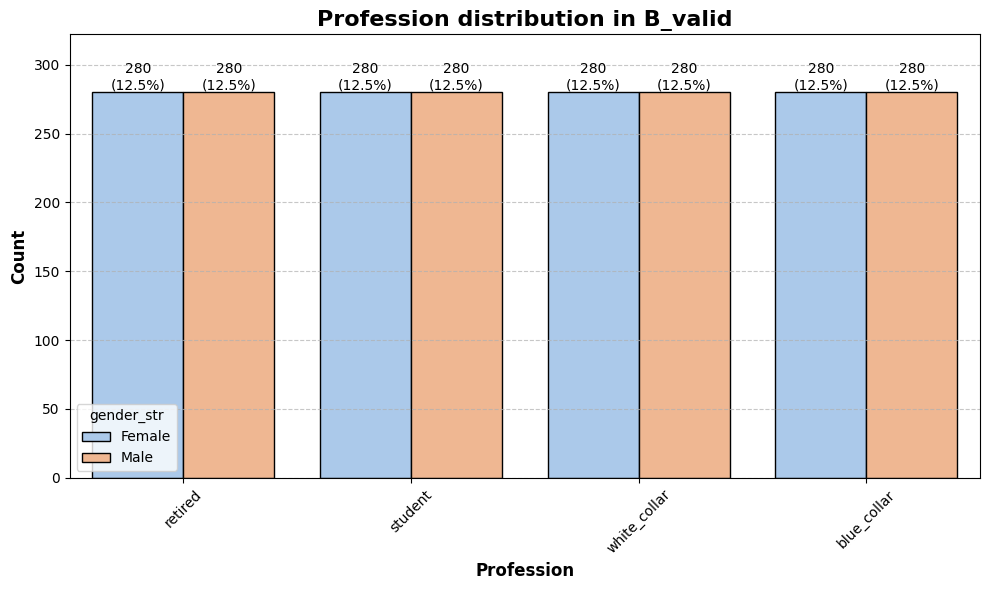


=== C_train ===
Total count: 17696

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar     304
                             retired         333
                             student         284
                             white_collar    333
            East Asian       blue_collar     327
                             retired         294
                             student         297
                             white_collar    311
            Indian           blue_collar     316
                             retired         328
                             student         333
                             white_collar    276
            Latino_Hispanic  blue_collar     306
                             retired         324
                             student         339
                             white_collar    311
            Middle Eastern   blue_collar     198
                             retired      

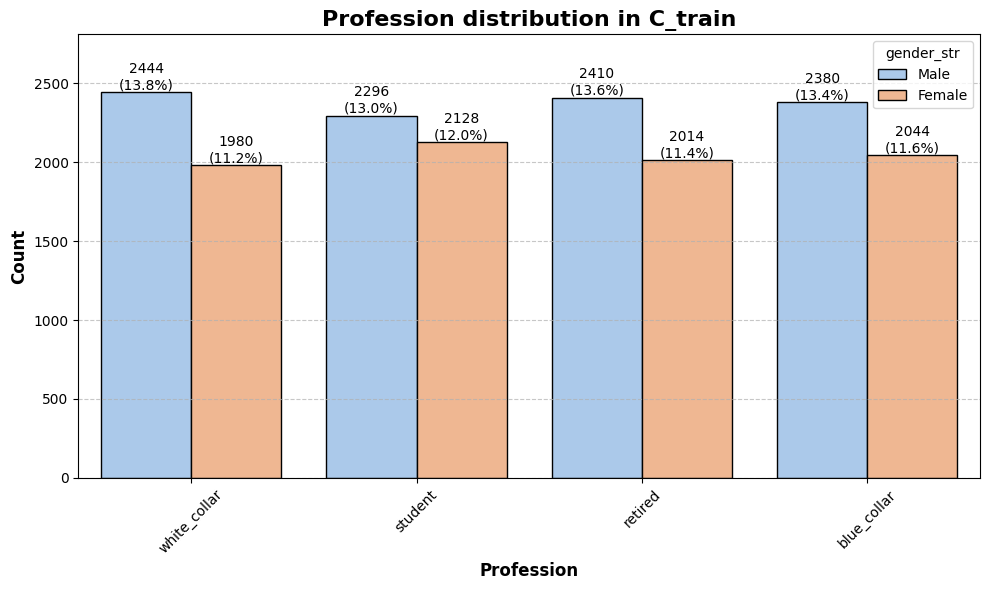


=== C_valid ===
Total count: 1960

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar     34
                             retired         40
                             student         34
                             white_collar    35
            East Asian       blue_collar     32
                             retired         38
                             student         25
                             white_collar    29
            Indian           blue_collar     38
                             retired         35
                             student         37
                             white_collar    37
            Latino_Hispanic  blue_collar     43
                             retired         34
                             student         38
                             white_collar    35
            Middle Eastern   blue_collar     23
                             retired         16
            

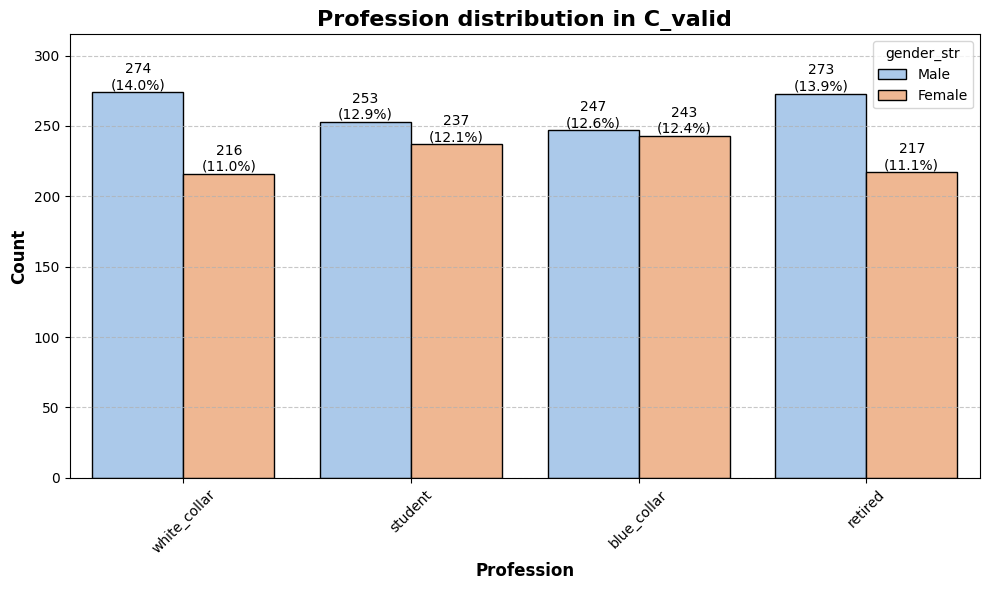


=== D_train ===
Total count: 39858

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar      686
                             retired          158
                             student          916
                             white_collar    1087
            East Asian       blue_collar      739
                             retired          143
                             student          837
                             white_collar    1128
            Indian           blue_collar      668
                             retired          203
                             student          884
                             white_collar    1092
            Latino_Hispanic  blue_collar      714
                             retired          150
                             student          900
                             white_collar    1083
            Middle Eastern   blue_collar      769
                         

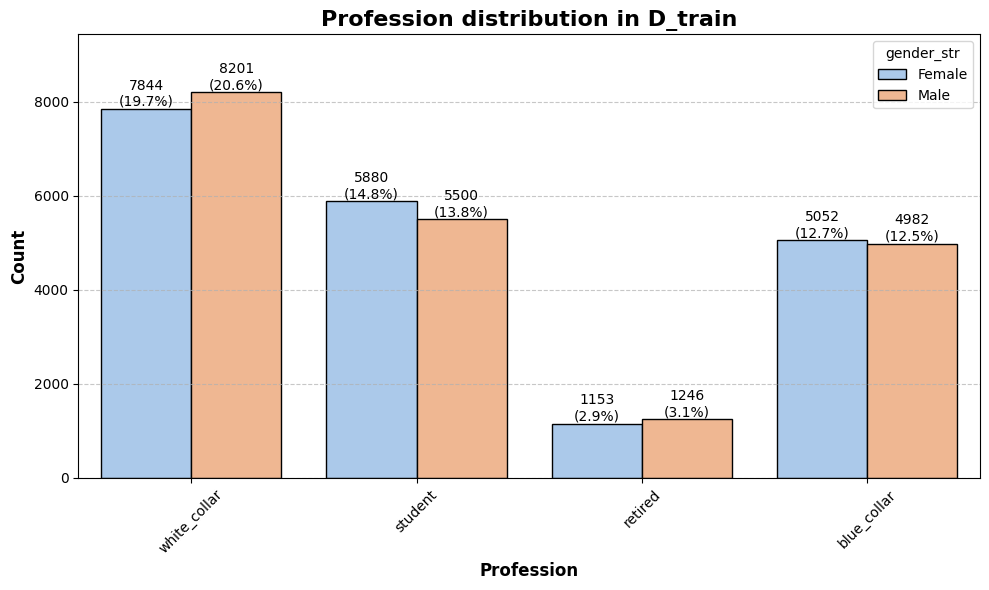


=== D_valid ===
Total count: 5544

Distribution by gender, race, and profession:
gender_str  race_str         profession  
Female      Black            blue_collar      83
                             retired          17
                             student         128
                             white_collar    168
            East Asian       blue_collar     121
                             retired          22
                             student         112
                             white_collar    141
            Indian           blue_collar      99
                             retired          22
                             student         117
                             white_collar    158
            Latino_Hispanic  blue_collar     108
                             retired          19
                             student         117
                             white_collar    152
            Middle Eastern   blue_collar      99
                             retired       

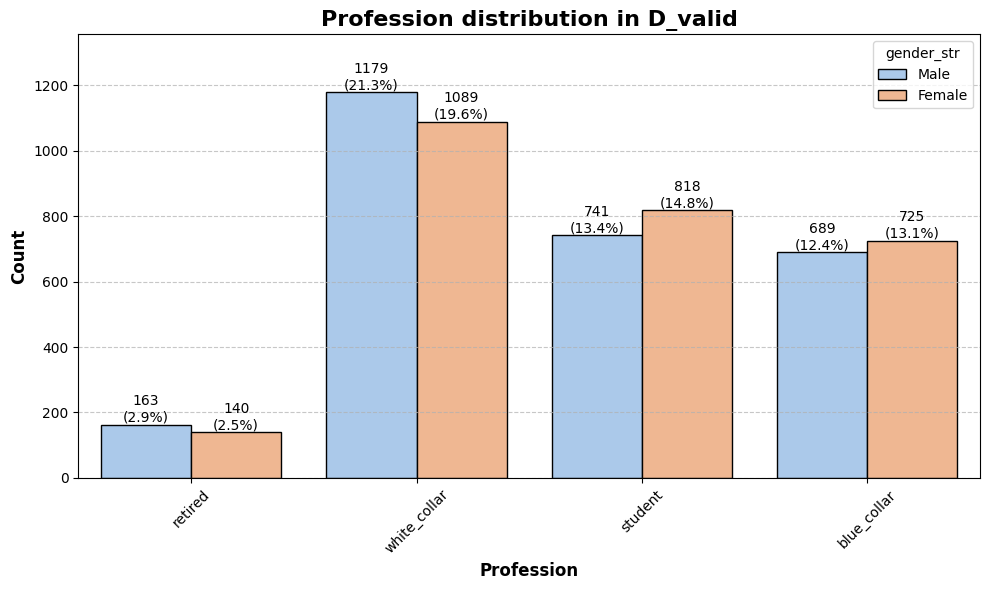

In [20]:
for name, ds in datasets_dict.items():
    summarize_dataset(ds, name)
    plot_distribution(ds, "profession", f"Profession distribution in {name}")

As we can see our datasets had the strings columns (added to visualize), so now we have to remove it in order to train:

In [21]:
datasets_dict["B_train"]

Dataset({
    features: ['image', 'age', 'gender', 'race', 'service_test', 'race_str', 'gender_str', 'age_str', 'service_test_str', 'profession'],
    num_rows: 19288
})

In [22]:
# Columns to remove (all the string helpers to visualize)
remove_cols = ["race_str", "gender_str", "age_str", "service_test_str"]

def clean_dataset(ds):
    cols_to_remove = [c for c in remove_cols if c in ds.column_names]
    if cols_to_remove:
        ds = ds.remove_columns(cols_to_remove)
    return ds

# Apply to every dataset in the dictionary
for name in datasets_dict:
    datasets_dict[name] = clean_dataset(datasets_dict[name])

# Quick check
datasets_dict["B_train"]


Dataset({
    features: ['image', 'age', 'gender', 'race', 'service_test', 'profession'],
    num_rows: 19288
})

In [23]:
# Row sample of B train dataset
datasets_dict["B_train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'age': 7,
 'gender': 0,
 'race': 3,
 'service_test': False,
 'profession': 'white_collar'}

#### Summary of Experimental Datasets

| Dataset | Split | Total Samples | Intended Imbalance              | Sensitive Attribute(s) Affected | Degree of Imbalance | Notes                                                                                                             |
| ------- | ----- | ------------- | ------------------------------- | ------------------------------- | ------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **A**   | Train | 9,128         | None (Perfectly balanced)       | Gender, Race, Profession        | 0%                  | Uniform distribution across all combinations of gender × race × profession                                        |
| **A**   | Valid | 896           | None (Perfectly balanced)       | Gender, Race, Profession        | 0%                  | Exact proportional consistency with training set                                                                  |
| **B**   | Train | 19,288        | Race imbalance                  | Race                            | Moderate            | Unequal sample counts across racial groups while maintaining a balanced profession distribution                   |
| **B**   | Valid | 2,240         | Race imbalance                  | Race                            | Moderate            | Validation mirrors racial skew present in training                                                                |
| **C**   | Train | 17,696        | Gender imbalance                | Gender                          | Moderate            | Unequal representation between genders; race and profession perfectly balanced                                |
| **C**   | Valid | 1,960         | Gender imbalance                | Gender                          | Moderate            | Validation preserves gender skew from training                                                                    |
| **D**   | Train | 39,858        | Natural (no enforced balancing) | None (observational setting)    | High (target)       | Profession (target label) follows a natural, non-uniform distribution; gender and race are perfectly balanced |
| **D**   | Valid | 5,544         | Natural (no enforced balancing) | None (observational setting)    | High (target)       | Validation preserves the same natural target distribution as training                                             |

#### Experimental Design Notes

* In **Datasets A, B, and C**, the **target variable (profession)** is **perfectly balanced**, with each class representing exactly **25%** of the samples.
* In **Dataset D**, the **profession label is intentionally left neutral**, reflecting a **realistic, naturally imbalanced distribution** (e.g., white-collar dominance and under-representation of retired individuals).
* For **B and C**, imbalance is **introduced exclusively in sensitive attributes** (race or gender), enabling controlled fairness analysis.
* **Dataset D** serves as a **real-world baseline**, where no artificial balancing is applied and fairness effects emerge from naturally occurring data distributions.

### 5.4 Training

To make more user-friendly this section, we created a ```training``` package. This package is designed to provide a **modular and reproducible pipeline** for training classification models with fairness evaluation. The key components are:

#### Dataset Handling

* **Custom Dataset**: `FairFaceDataset` wraps standard datasets (like `HFDataset`) and adds support for:

  * Applying **transformations**.
  * Extracting **sensitive attributes** (e.g., profession, race, gender) for fairness evaluation.
* **Transforms**:

  * **Training** (`train_transforms`): includes augmentations like random cropping, flipping, color jitter, and normalization for robust learning.
  * **Validation** (`valid_transforms`): deterministic transformations (resize + normalize) to maintain evaluation consistency.
* **DataLoaders**:

  * `shuffle=True` for training, `shuffle=False` for validation.
  * Supports batching, multiple workers, and `pin_memory=True` for GPU efficiency.

#### Model Architecture

* Supports multiple pre-trained backbones:

  * `resnet50`, `mobilenet_v2`, `fairface_yolo`.
* Automatically adapts the final classification layer to the number of target classes (`num_classes`).
* Can **resume from a checkpoint**, enabling interrupted experiments to continue seamlessly.


#### Loss and Optimization

* **Weighted Loss**:

  * Class imbalance is handled automatically via `get_weighted_loss`.
* **Optimizer**:

  * `AdamW` with grouped learning rates (different LR for backbone vs classifier layer).
* **Learning Rate Scheduler**:

  * `OneCycleLR` with cosine annealing and a configurable `pct_start` for warm-up.

#### Training Loop

The main training function `train_model` handles:

1. **Epoch Loop**:

   * Train one epoch → compute training metrics.
   * Validate → compute validation metrics and fairness metrics.
2. **Metrics Tracking**:

   * `loss`, `accuracy`, `balanced_accuracy`, `F1`.
   * Early stopping if validation performance does not improve for `early_stopping_patience` epochs.
3. **Checkpointing**:

   * Saves the best model automatically based on validation performance.
4. **Optional Interpretability**:

   * Grad-CAM visualization for selected layers.

#### Fairness Evaluation

* Fairness is computed for a **target attribute** across **sensitive groups**.
* Method:

  * Convert multiclass targets into **binary tasks** per target class.
  * Compare **pairs of sensitive groups** to compute:

    * **Demographic Parity Difference**
    * **Equal Opportunity Difference**
  * Skip combinations with insufficient samples to avoid statistical noise.
* Works with any attribute: `profession`, `race`, `gender`.

#### Configuration

* Experiments are configurable via `TrainingConfig` object:

  * `batch_size`, `epochs`, `num_classes`, `learning_rate`.
  * `model_name` to select backbone.
  * `early_stopping_patience` for training stability.
  * Checkpoint directory and logging are automatically managed.

#### Summary

The training package provides a **complete, end-to-end pipeline** for classification tasks:

* Flexible data loading and augmentation
* Pretrained backbone selection
* Weighted loss and advanced optimization
* Integrated evaluation of **performance** and **fairness**
* Logging, checkpointing, and early stopping

This modular design makes it easy to **define new experiments** while maintaining **consistent evaluation and reproducibility**.

Now we configure some essentials training hyperparameters. We will use this setup, but feel free to change it here and also in the ```training``` package.
In this notebook we only experiment with a subset of all the possiblities so this could be extended in the future.

In [25]:
BATCH_SIZE = 64
EPOCHS = 20
LR = 5e-4
NUM_CLASSES = 4  # student, blue_collar, white_collar, retired
MODEL_NAME = "resnet50"  # could be resnet50, mobilenet_v2 or fairface_yolo

Import classes/functions in order to train:

In [26]:
from training import train_model, TrainingConfig

We would use the same configuration across all the experiments:

In [27]:
config = TrainingConfig(
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    num_classes=NUM_CLASSES,
    learning_rate=LR,
    model_name=MODEL_NAME,
    early_stopping_patience=7
)

**Train a model for experiment A**

In [ ]:
train_model(
    train_ds=datasets_dict["A_train"],
    valid_ds=datasets_dict["A_valid"],
    config=config,
    experiment_name="A",
    sensitive_attr="profession"
)

2025-12-19 17:36:25 - INFO - ======================================================================
2025-12-19 17:36:25 - INFO - Starting training: Experiment 'A' | Model: resnet50
2025-12-19 17:36:25 - INFO - ======================================================================
2025-12-19 17:36:25 - INFO - Preparing datasets...
2025-12-19 17:36:25 - INFO - Training samples: 9128 | Validation samples: 896
2025-12-19 17:36:25 - INFO - Initializing model...
2025-12-19 17:36:57 - INFO -  Starting training from scratch
2025-12-19 17:36:57 - INFO - Starting training loop...
2025-12-19 17:36:57 - INFO - 
--- Epoch [1/20] ---
2025-12-19 17:38:18 - INFO - Train → Loss: 1.3978 | Acc: 0.2551 | Bal.Acc: 0.2551 | F1: 0.2548
2025-12-19 17:38:18 - INFO - Valid → Loss: 1.3828 | Acc: 0.2734 | Bal.Acc: 0.2734 | F1: 0.2737


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:38:19 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:38:19 - INFO - 
--- Epoch [2/20] ---
2025-12-19 17:39:39 - INFO - Train → Loss: 1.3905 | Acc: 0.2685 | Bal.Acc: 0.2685 | F1: 0.2683
2025-12-19 17:39:39 - INFO - Valid → Loss: 1.3770 | Acc: 0.3047 | Bal.Acc: 0.3047 | F1: 0.2928


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:39:39 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:39:39 - INFO - 
--- Epoch [3/20] ---
2025-12-19 17:41:01 - INFO - Train → Loss: 1.3881 | Acc: 0.2714 | Bal.Acc: 0.2714 | F1: 0.2701
2025-12-19 17:41:01 - INFO - Valid → Loss: 1.3714 | Acc: 0.3114 | Bal.Acc: 0.3114 | F1: 0.3080


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:41:01 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:41:01 - INFO - 
--- Epoch [4/20] ---
2025-12-19 17:42:21 - INFO - Train → Loss: 1.3818 | Acc: 0.2956 | Bal.Acc: 0.2956 | F1: 0.2922
2025-12-19 17:42:21 - INFO - Valid → Loss: 1.3654 | Acc: 0.3449 | Bal.Acc: 0.3449 | F1: 0.3324


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:42:22 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:42:22 - INFO - 
--- Epoch [5/20] ---
2025-12-19 17:43:42 - INFO - Train → Loss: 1.3778 | Acc: 0.2842 | Bal.Acc: 0.2842 | F1: 0.2816
2025-12-19 17:43:42 - INFO - Valid → Loss: 1.3600 | Acc: 0.3493 | Bal.Acc: 0.3493 | F1: 0.3329


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:43:42 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:43:42 - INFO - 
--- Epoch [6/20] ---
2025-12-19 17:45:03 - INFO - Train → Loss: 1.3712 | Acc: 0.2881 | Bal.Acc: 0.2881 | F1: 0.2863
2025-12-19 17:45:03 - INFO - Valid → Loss: 1.3533 | Acc: 0.3594 | Bal.Acc: 0.3594 | F1: 0.3455


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:45:04 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:45:04 - INFO - 
--- Epoch [7/20] ---
2025-12-19 17:46:26 - INFO - Train → Loss: 1.3702 | Acc: 0.2932 | Bal.Acc: 0.2932 | F1: 0.2896
2025-12-19 17:46:26 - INFO - Valid → Loss: 1.3463 | Acc: 0.3638 | Bal.Acc: 0.3638 | F1: 0.3329


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:46:26 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:46:26 - INFO - 
--- Epoch [8/20] ---
2025-12-19 17:47:48 - INFO - Train → Loss: 1.3641 | Acc: 0.3072 | Bal.Acc: 0.3072 | F1: 0.3030
2025-12-19 17:47:48 - INFO - Valid → Loss: 1.3398 | Acc: 0.3694 | Bal.Acc: 0.3694 | F1: 0.3305


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:47:48 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:47:48 - INFO - 
--- Epoch [9/20] ---
2025-12-19 17:49:10 - INFO - Train → Loss: 1.3566 | Acc: 0.3176 | Bal.Acc: 0.3176 | F1: 0.3101
2025-12-19 17:49:10 - INFO - Valid → Loss: 1.3319 | Acc: 0.3705 | Bal.Acc: 0.3705 | F1: 0.3430


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:49:10 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:49:10 - INFO - 
--- Epoch [10/20] ---
2025-12-19 17:50:31 - INFO - Train → Loss: 1.3509 | Acc: 0.3183 | Bal.Acc: 0.3183 | F1: 0.3124
2025-12-19 17:50:31 - INFO - Valid → Loss: 1.3240 | Acc: 0.3683 | Bal.Acc: 0.3683 | F1: 0.3320


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:50:31 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:50:31 - INFO - 
--- Epoch [11/20] ---
2025-12-19 17:51:53 - INFO - Train → Loss: 1.3497 | Acc: 0.3192 | Bal.Acc: 0.3192 | F1: 0.3095
2025-12-19 17:51:53 - INFO - Valid → Loss: 1.3162 | Acc: 0.3661 | Bal.Acc: 0.3661 | F1: 0.3286


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:51:53 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:51:53 - INFO - 
--- Epoch [12/20] ---
2025-12-19 17:53:14 - INFO - Train → Loss: 1.3405 | Acc: 0.3301 | Bal.Acc: 0.3301 | F1: 0.3220
2025-12-19 17:53:14 - INFO - Valid → Loss: 1.3080 | Acc: 0.3862 | Bal.Acc: 0.3862 | F1: 0.3550


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:53:15 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:53:15 - INFO - 
--- Epoch [13/20] ---
2025-12-19 17:54:36 - INFO - Train → Loss: 1.3377 | Acc: 0.3353 | Bal.Acc: 0.3353 | F1: 0.3299
2025-12-19 17:54:36 - INFO - Valid → Loss: 1.3020 | Acc: 0.3795 | Bal.Acc: 0.3795 | F1: 0.3454


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:54:36 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:54:36 - INFO - 
--- Epoch [14/20] ---
2025-12-19 17:55:58 - INFO - Train → Loss: 1.3337 | Acc: 0.3325 | Bal.Acc: 0.3325 | F1: 0.3258
2025-12-19 17:55:58 - INFO - Valid → Loss: 1.2977 | Acc: 0.3839 | Bal.Acc: 0.3839 | F1: 0.3427


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:55:58 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:55:58 - INFO - 
--- Epoch [15/20] ---
2025-12-19 17:57:21 - INFO - Train → Loss: 1.3265 | Acc: 0.3447 | Bal.Acc: 0.3447 | F1: 0.3343
2025-12-19 17:57:21 - INFO - Valid → Loss: 1.2902 | Acc: 0.3761 | Bal.Acc: 0.3761 | F1: 0.3457


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:57:22 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:57:22 - INFO - 
--- Epoch [16/20] ---
2025-12-19 17:58:46 - INFO - Train → Loss: 1.3227 | Acc: 0.3477 | Bal.Acc: 0.3477 | F1: 0.3379
2025-12-19 17:58:46 - INFO - Valid → Loss: 1.2866 | Acc: 0.3940 | Bal.Acc: 0.3940 | F1: 0.3583


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 17:58:46 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 17:58:46 - INFO - 
--- Epoch [17/20] ---
2025-12-19 18:00:08 - INFO - Train → Loss: 1.3198 | Acc: 0.3470 | Bal.Acc: 0.3470 | F1: 0.3398
2025-12-19 18:00:08 - INFO - Valid → Loss: 1.2816 | Acc: 0.3895 | Bal.Acc: 0.3895 | F1: 0.3540


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 18:00:08 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 18:00:08 - INFO - 
--- Epoch [18/20] ---
2025-12-19 18:01:31 - INFO - Train → Loss: 1.3143 | Acc: 0.3513 | Bal.Acc: 0.3513 | F1: 0.3405
2025-12-19 18:01:31 - INFO - Valid → Loss: 1.2785 | Acc: 0.3962 | Bal.Acc: 0.3962 | F1: 0.3628


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 18:01:32 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 18:01:32 - INFO - 
--- Epoch [19/20] ---
2025-12-19 18:02:54 - INFO - Train → Loss: 1.3136 | Acc: 0.3586 | Bal.Acc: 0.3586 | F1: 0.3492
2025-12-19 18:02:54 - INFO - Valid → Loss: 1.2777 | Acc: 0.3917 | Bal.Acc: 0.3917 | F1: 0.3596


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 18:02:54 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 18:02:54 - INFO - 
--- Epoch [20/20] ---
2025-12-19 18:04:16 - INFO - Train → Loss: 1.3095 | Acc: 0.3541 | Bal.Acc: 0.3541 | F1: 0.3433
2025-12-19 18:04:16 - INFO - Valid → Loss: 1.2756 | Acc: 0.4018 | Bal.Acc: 0.4018 | F1: 0.3718


Comparing student vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing student vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs white_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing blue_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----
Comparing white_collar vs retired
Demographic Parity: 0.0000
Equal Opportunity: 0.0000
-----


2025-12-19 18:04:16 - INFO - Best model saved at path: ../checkpoints\A_resnet50_best.pth
2025-12-19 18:04:16 - INFO - 
2025-12-19 18:04:16 - INFO - Training completed: A
2025-12-19 18:04:16 - INFO - Best Validation loss (minimized): 1.2756 at epoch 20
2025-12-19 18:04:16 - INFO - ======================================================================



(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

In [27]:
train_model(
    train_ds=datasets_dict["B_train"],
    valid_ds=datasets_dict["B_valid"],
    config=config,
    experiment_name="B",
    sensitive_attr="race"
)

2026-01-08 12:53:55 - INFO - ======================================================================
2026-01-08 12:53:55 - INFO - Starting training: Experiment 'B' | Model: resnet50
2026-01-08 12:53:55 - INFO - ======================================================================
2026-01-08 12:53:55 - INFO - Preparing datasets...
2026-01-08 12:53:55 - INFO - Training samples: 19288 | Validation samples: 2240
2026-01-08 12:53:55 - INFO - Initializing model...
2026-01-08 12:55:06 - INFO -  Starting training from scratch
2026-01-08 12:55:06 - INFO - Starting training loop...
2026-01-08 12:55:06 - INFO - 
--- Epoch [1/20] ---
2026-01-08 12:58:00 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 12:58:00 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 12:58:00 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 12:58:00 - INFO - 

Comparing 0 vs East Asian
Demographic Parity: 0.1599
Equal Opportunity: 0.1705
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1965
Equal Opportunity: 0.2604
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1843
Equal Opportunity: 0.1331
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2001
Equal Opportunity: 0.2819
-----
Comparing 0 vs East Asian
Demographic Parity: 0.0729
Equal Opportunity: 0.1179
-----
Comparing 0 vs East Asian
Demographic Parity: 0.0844
Equal Opportunity: 0.1205
-----
Comparing 0 vs Indian
Demographic Parity: 0.0365
Equal Opportunity: 0.0899
-----
Comparing 0 vs Indian
Demographic Parity: 0.0243
Equal Opportunity: 0.0374
-----
Comparing 0 vs Indian
Demographic Parity: 0.0402
Equal Opportunity: 0.1114
-----
Comparing 0 vs Indian
Demographic Parity: 0.0870
Equal Opportunity: 0.0526
-----
Comparing 0 vs Indian
Demographic Parity: 0.0756
Equal Opportunity: 0.0501
-----
Comparing 0 vs Black
Demographic Parity: 0.0122
Equal Opportunity: 0.1273
-----
Compa

2026-01-08 12:58:03 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 12:58:03 - INFO - 
--- Epoch [2/20] ---
2026-01-08 13:00:56 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:00:56 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:00:56 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:00:56 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:00:56 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:00:56 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:00:56 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Eas

Comparing 0 vs East Asian
Demographic Parity: 0.2209
Equal Opportunity: 0.2045
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2342
Equal Opportunity: 0.2045
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1786
Equal Opportunity: 0.1023
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2755
Equal Opportunity: 0.2483
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1277
Equal Opportunity: 0.0857
-----
Comparing 0 vs East Asian
Demographic Parity: 0.0843
Equal Opportunity: 0.0614
-----
Comparing 0 vs Indian
Demographic Parity: 0.0133
Equal Opportunity: 0.0000
-----
Comparing 0 vs Indian
Demographic Parity: 0.0423
Equal Opportunity: 0.1022
-----
Comparing 0 vs Indian
Demographic Parity: 0.0546
Equal Opportunity: 0.0438
-----
Comparing 0 vs Indian
Demographic Parity: 0.0933
Equal Opportunity: 0.1188
-----
Comparing 0 vs Indian
Demographic Parity: 0.1366
Equal Opportunity: 0.1431
-----
Comparing 0 vs Black
Demographic Parity: 0.0556
Equal Opportunity: 0.1022
-----
Compa

2026-01-08 13:00:59 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:00:59 - INFO - 
--- Epoch [3/20] ---
2026-01-08 13:03:52 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:03:52 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:03:52 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:03:52 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:03:52 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:03:52 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:03:52 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Eas

Comparing 0 vs East Asian
Demographic Parity: 0.2458
Equal Opportunity: 0.2444
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2403
Equal Opportunity: 0.2331
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2261
Equal Opportunity: 0.1802
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2652
Equal Opportunity: 0.2672
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1469
Equal Opportunity: 0.1500
-----
Comparing 0 vs East Asian
Demographic Parity: 0.0894
Equal Opportunity: 0.0568
-----
Comparing 0 vs Indian
Demographic Parity: 0.0054
Equal Opportunity: 0.0112
-----
Comparing 0 vs Indian
Demographic Parity: 0.0197
Equal Opportunity: 0.0641
-----
Comparing 0 vs Indian
Demographic Parity: 0.0194
Equal Opportunity: 0.0229
-----
Comparing 0 vs Indian
Demographic Parity: 0.0989
Equal Opportunity: 0.0944
-----
Comparing 0 vs Indian
Demographic Parity: 0.1564
Equal Opportunity: 0.1876
-----
Comparing 0 vs Black
Demographic Parity: 0.0143
Equal Opportunity: 0.0529
-----
Compa

2026-01-08 13:03:55 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:03:55 - INFO - 
--- Epoch [4/20] ---
2026-01-08 13:06:51 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:06:51 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:06:51 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:06:51 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:06:51 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:06:51 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:06:51 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Eas

Comparing 0 vs East Asian
Demographic Parity: 0.2433
Equal Opportunity: 0.2183
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2440
Equal Opportunity: 0.1508
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2317
Equal Opportunity: 0.1273
-----
Comparing 0 vs East Asian
Demographic Parity: 0.3110
Equal Opportunity: 0.2905
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1898
Equal Opportunity: 0.1393
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1097
Equal Opportunity: 0.0068
-----
Comparing 0 vs Indian
Demographic Parity: 0.0007
Equal Opportunity: 0.0674
-----
Comparing 0 vs Indian
Demographic Parity: 0.0116
Equal Opportunity: 0.0909
-----
Comparing 0 vs Indian
Demographic Parity: 0.0677
Equal Opportunity: 0.0723
-----
Comparing 0 vs Indian
Demographic Parity: 0.0535
Equal Opportunity: 0.0790
-----
Comparing 0 vs Indian
Demographic Parity: 0.1336
Equal Opportunity: 0.2114
-----
Comparing 0 vs Black
Demographic Parity: 0.0123
Equal Opportunity: 0.0235
-----
Compa

2026-01-08 13:06:54 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:06:54 - INFO - 
--- Epoch [5/20] ---
2026-01-08 13:09:47 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:09:47 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:09:47 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:09:47 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:09:47 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:09:47 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:09:47 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Eas

Comparing 0 vs East Asian
Demographic Parity: 0.2633
Equal Opportunity: 0.2607
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2355
Equal Opportunity: 0.1708
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2432
Equal Opportunity: 0.2302
-----
Comparing 0 vs East Asian
Demographic Parity: 0.3100
Equal Opportunity: 0.2828
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1990
Equal Opportunity: 0.1429
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1104
Equal Opportunity: 0.0159
-----
Comparing 0 vs Indian
Demographic Parity: 0.0279
Equal Opportunity: 0.0899
-----
Comparing 0 vs Indian
Demographic Parity: 0.0202
Equal Opportunity: 0.0304
-----
Comparing 0 vs Indian
Demographic Parity: 0.0466
Equal Opportunity: 0.0221
-----
Comparing 0 vs Indian
Demographic Parity: 0.0643
Equal Opportunity: 0.1178
-----
Comparing 0 vs Indian
Demographic Parity: 0.1530
Equal Opportunity: 0.2448
-----
Comparing 0 vs Black
Demographic Parity: 0.0077
Equal Opportunity: 0.0594
-----
Compa

2026-01-08 13:09:50 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:09:50 - INFO - 
--- Epoch [6/20] ---
2026-01-08 13:12:42 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:12:42 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:12:42 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:12:42 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:12:42 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:12:42 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:12:42 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Eas

Comparing 0 vs East Asian
Demographic Parity: 0.2670
Equal Opportunity: 0.2295
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2183
Equal Opportunity: 0.1621
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2563
Equal Opportunity: 0.1971
-----
Comparing 0 vs East Asian
Demographic Parity: 0.3145
Equal Opportunity: 0.3078
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2090
Equal Opportunity: 0.1536
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1110
Equal Opportunity: 0.0182
-----
Comparing 0 vs Indian
Demographic Parity: 0.0487
Equal Opportunity: 0.0674
-----
Comparing 0 vs Indian
Demographic Parity: 0.0107
Equal Opportunity: 0.0324
-----
Comparing 0 vs Indian
Demographic Parity: 0.0475
Equal Opportunity: 0.0783
-----
Comparing 0 vs Indian
Demographic Parity: 0.0580
Equal Opportunity: 0.0759
-----
Comparing 0 vs Indian
Demographic Parity: 0.1560
Equal Opportunity: 0.2113
-----
Comparing 0 vs Black
Demographic Parity: 0.0380
Equal Opportunity: 0.0350
-----
Compa

2026-01-08 13:12:45 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:12:45 - INFO - 
--- Epoch [7/20] ---
2026-01-08 13:15:35 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:15:35 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:15:35 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:15:35 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:15:35 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:15:35 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:15:35 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Eas

Comparing 0 vs East Asian
Demographic Parity: 0.2696
Equal Opportunity: 0.2407
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2086
Equal Opportunity: 0.1846
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2796
Equal Opportunity: 0.2436
-----
Comparing 0 vs East Asian
Demographic Parity: 0.3142
Equal Opportunity: 0.2733
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2329
Equal Opportunity: 0.1821
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1384
Equal Opportunity: 0.0295
-----
Comparing 0 vs Indian
Demographic Parity: 0.0611
Equal Opportunity: 0.0562
-----
Comparing 0 vs Indian
Demographic Parity: 0.0100
Equal Opportunity: 0.0029
-----
Comparing 0 vs Indian
Demographic Parity: 0.0446
Equal Opportunity: 0.0325
-----
Comparing 0 vs Indian
Demographic Parity: 0.0368
Equal Opportunity: 0.0586
-----
Comparing 0 vs Indian
Demographic Parity: 0.1312
Equal Opportunity: 0.2112
-----
Comparing 0 vs Black
Demographic Parity: 0.0711
Equal Opportunity: 0.0591
-----
Compa

2026-01-08 13:15:38 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:15:38 - INFO - 
--- Epoch [8/20] ---
2026-01-08 13:18:29 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:18:29 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:18:29 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:18:29 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:18:29 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:18:29 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:18:29 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Eas

Comparing 0 vs East Asian
Demographic Parity: 0.2447
Equal Opportunity: 0.1621
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1983
Equal Opportunity: 0.1733
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2679
Equal Opportunity: 0.1971
-----
Comparing 0 vs East Asian
Demographic Parity: 0.3037
Equal Opportunity: 0.2560
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2332
Equal Opportunity: 0.1536
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1387
Equal Opportunity: 0.0182
-----
Comparing 0 vs Indian
Demographic Parity: 0.0465
Equal Opportunity: 0.0112
-----
Comparing 0 vs Indian
Demographic Parity: 0.0232
Equal Opportunity: 0.0350
-----
Comparing 0 vs Indian
Demographic Parity: 0.0589
Equal Opportunity: 0.0940
-----
Comparing 0 vs Indian
Demographic Parity: 0.0115
Equal Opportunity: 0.0085
-----
Comparing 0 vs Indian
Demographic Parity: 0.1060
Equal Opportunity: 0.1439
-----
Comparing 0 vs Black
Demographic Parity: 0.0697
Equal Opportunity: 0.0238
-----
Compa

2026-01-08 13:18:38 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:18:38 - INFO - 
--- Epoch [9/20] ---
2026-01-08 13:21:29 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:21:29 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:21:29 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:21:29 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:21:29 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:21:29 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:21:29 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Eas

Comparing 0 vs East Asian
Demographic Parity: 0.2367
Equal Opportunity: 0.1659
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1972
Equal Opportunity: 0.1434
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2879
Equal Opportunity: 0.2113
-----
Comparing 0 vs East Asian
Demographic Parity: 0.3140
Equal Opportunity: 0.2935
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2415
Equal Opportunity: 0.1482
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1404
Equal Opportunity: 0.0102
-----
Comparing 0 vs Indian
Demographic Parity: 0.0395
Equal Opportunity: 0.0225
-----
Comparing 0 vs Indian
Demographic Parity: 0.0513
Equal Opportunity: 0.0455
-----
Comparing 0 vs Indian
Demographic Parity: 0.0773
Equal Opportunity: 0.1277
-----
Comparing 0 vs Indian
Demographic Parity: 0.0048
Equal Opportunity: 0.0177
-----
Comparing 0 vs Indian
Demographic Parity: 0.0962
Equal Opportunity: 0.1556
-----
Comparing 0 vs Black
Demographic Parity: 0.0908
Equal Opportunity: 0.0679
-----
Compa

2026-01-08 13:21:32 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:21:32 - INFO - 
--- Epoch [10/20] ---
2026-01-08 13:24:23 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:24:23 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:24:23 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:24:23 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:24:23 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:24:23 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:24:23 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Ea

Comparing 0 vs East Asian
Demographic Parity: 0.2143
Equal Opportunity: 0.1309
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1739
Equal Opportunity: 0.1197
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2736
Equal Opportunity: 0.1872
-----
Comparing 0 vs East Asian
Demographic Parity: 0.3084
Equal Opportunity: 0.2638
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2348
Equal Opportunity: 0.1214
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1181
Equal Opportunity: 0.0250
-----
Comparing 0 vs Indian
Demographic Parity: 0.0404
Equal Opportunity: 0.0112
-----
Comparing 0 vs Indian
Demographic Parity: 0.0593
Equal Opportunity: 0.0563
-----
Comparing 0 vs Indian
Demographic Parity: 0.0942
Equal Opportunity: 0.1329
-----
Comparing 0 vs Indian
Demographic Parity: 0.0205
Equal Opportunity: 0.0095
-----
Comparing 0 vs Indian
Demographic Parity: 0.0961
Equal Opportunity: 0.1559
-----
Comparing 0 vs Black
Demographic Parity: 0.0997
Equal Opportunity: 0.0675
-----
Compa

2026-01-08 13:24:26 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:24:26 - INFO - 
--- Epoch [11/20] ---
2026-01-08 13:27:16 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:27:16 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:27:16 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:27:16 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:27:16 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:27:17 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:27:17 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Ea

Comparing 0 vs East Asian
Demographic Parity: 0.2043
Equal Opportunity: 0.1322
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1676
Equal Opportunity: 0.1209
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2651
Equal Opportunity: 0.1997
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2996
Equal Opportunity: 0.2763
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2186
Equal Opportunity: 0.1482
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1019
Equal Opportunity: 0.0102
-----
Comparing 0 vs Indian
Demographic Parity: 0.0368
Equal Opportunity: 0.0112
-----
Comparing 0 vs Indian
Demographic Parity: 0.0607
Equal Opportunity: 0.0675
-----
Comparing 0 vs Indian
Demographic Parity: 0.0953
Equal Opportunity: 0.1441
-----
Comparing 0 vs Indian
Demographic Parity: 0.0143
Equal Opportunity: 0.0161
-----
Comparing 0 vs Indian
Demographic Parity: 0.1024
Equal Opportunity: 0.1219
-----
Comparing 0 vs Black
Demographic Parity: 0.0975
Equal Opportunity: 0.0788
-----
Compa

2026-01-08 13:27:20 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:27:20 - INFO - 
--- Epoch [12/20] ---
2026-01-08 13:30:09 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:30:09 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:30:09 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:30:09 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:30:09 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:30:09 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:30:09 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Ea

Comparing 0 vs East Asian
Demographic Parity: 0.2324
Equal Opportunity: 0.1409
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1610
Equal Opportunity: 0.1072
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2631
Equal Opportunity: 0.1515
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2974
Equal Opportunity: 0.2513
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2213
Equal Opportunity: 0.1232
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1297
Equal Opportunity: 0.0034
-----
Comparing 0 vs Indian
Demographic Parity: 0.0714
Equal Opportunity: 0.0337
-----
Comparing 0 vs Indian
Demographic Parity: 0.0307
Equal Opportunity: 0.0106
-----
Comparing 0 vs Indian
Demographic Parity: 0.0650
Equal Opportunity: 0.1104
-----
Comparing 0 vs Indian
Demographic Parity: 0.0111
Equal Opportunity: 0.0177
-----
Comparing 0 vs Indian
Demographic Parity: 0.1027
Equal Opportunity: 0.1443
-----
Comparing 0 vs Black
Demographic Parity: 0.1021
Equal Opportunity: 0.0443
-----
Compa

2026-01-08 13:30:12 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:30:12 - INFO - 
--- Epoch [13/20] ---
2026-01-08 13:33:03 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:33:03 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:33:03 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:33:03 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:33:03 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:33:03 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:33:03 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Ea

Comparing 0 vs East Asian
Demographic Parity: 0.2001
Equal Opportunity: 0.1296
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1516
Equal Opportunity: 0.1296
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2562
Equal Opportunity: 0.1863
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2788
Equal Opportunity: 0.2685
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2046
Equal Opportunity: 0.1232
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1224
Equal Opportunity: 0.0307
-----
Comparing 0 vs Indian
Demographic Parity: 0.0485
Equal Opportunity: 0.0000
-----
Comparing 0 vs Indian
Demographic Parity: 0.0561
Equal Opportunity: 0.0567
-----
Comparing 0 vs Indian
Demographic Parity: 0.0787
Equal Opportunity: 0.1389
-----
Comparing 0 vs Indian
Demographic Parity: 0.0045
Equal Opportunity: 0.0064
-----
Comparing 0 vs Indian
Demographic Parity: 0.0777
Equal Opportunity: 0.0990
-----
Comparing 0 vs Black
Demographic Parity: 0.1045
Equal Opportunity: 0.0567
-----
Compa

2026-01-08 13:33:06 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:33:06 - INFO - 
--- Epoch [14/20] ---
2026-01-08 13:35:57 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:35:57 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:35:57 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:35:57 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:35:57 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:35:57 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:35:57 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Ea

Comparing 0 vs East Asian
Demographic Parity: 0.1948
Equal Opportunity: 0.1209
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1542
Equal Opportunity: 0.1097
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2709
Equal Opportunity: 0.1881
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2836
Equal Opportunity: 0.2763
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2123
Equal Opportunity: 0.1054
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1143
Equal Opportunity: 0.0216
-----
Comparing 0 vs Indian
Demographic Parity: 0.0406
Equal Opportunity: 0.0112
-----
Comparing 0 vs Indian
Demographic Parity: 0.0761
Equal Opportunity: 0.0672
-----
Comparing 0 vs Indian
Demographic Parity: 0.0888
Equal Opportunity: 0.1554
-----
Comparing 0 vs Indian
Demographic Parity: 0.0175
Equal Opportunity: 0.0156
-----
Comparing 0 vs Indian
Demographic Parity: 0.0805
Equal Opportunity: 0.0993
-----
Comparing 0 vs Black
Demographic Parity: 0.1167
Equal Opportunity: 0.0784
-----
Compa

2026-01-08 13:38:50 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:38:50 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:38:51 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:38:51 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:38:51 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:38:51 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:38:51 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'East Asian': 306, 'Southeast Asian': 321}
2026-01-08 13:38:51 - INFO - target=0 | groups=(Indian,Black) computed | n=615, counts={'Black': 297,

Comparing 0 vs East Asian
Demographic Parity: 0.1929
Equal Opportunity: 0.1396
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1287
Equal Opportunity: 0.1171
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2470
Equal Opportunity: 0.1738
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2687
Equal Opportunity: 0.2388
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2094
Equal Opportunity: 0.1536
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1057
Equal Opportunity: 0.0068
-----
Comparing 0 vs Indian
Demographic Parity: 0.0642
Equal Opportunity: 0.0225
-----
Comparing 0 vs Indian
Demographic Parity: 0.0540
Equal Opportunity: 0.0342
-----
Comparing 0 vs Indian
Demographic Parity: 0.0758
Equal Opportunity: 0.0992
-----
Comparing 0 vs Indian
Demographic Parity: 0.0165
Equal Opportunity: 0.0140
-----
Comparing 0 vs Indian
Demographic Parity: 0.0872
Equal Opportunity: 0.1328
-----
Comparing 0 vs Black
Demographic Parity: 0.1182
Equal Opportunity: 0.0567
-----
Compa

2026-01-08 13:38:54 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:38:54 - INFO - 
--- Epoch [16/20] ---
2026-01-08 13:41:46 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:41:46 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:41:46 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:41:46 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:41:46 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:41:46 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:41:46 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Ea

Comparing 0 vs East Asian
Demographic Parity: 0.1922
Equal Opportunity: 0.1383
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1192
Equal Opportunity: 0.1046
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2433
Equal Opportunity: 0.1846
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2662
Equal Opportunity: 0.2263
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2175
Equal Opportunity: 0.1411
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1111
Equal Opportunity: 0.0170
-----
Comparing 0 vs Indian
Demographic Parity: 0.0730
Equal Opportunity: 0.0337
-----
Comparing 0 vs Indian
Demographic Parity: 0.0511
Equal Opportunity: 0.0463
-----
Comparing 0 vs Indian
Demographic Parity: 0.0740
Equal Opportunity: 0.0880
-----
Comparing 0 vs Indian
Demographic Parity: 0.0253
Equal Opportunity: 0.0027
-----
Comparing 0 vs Indian
Demographic Parity: 0.0811
Equal Opportunity: 0.1213
-----
Comparing 0 vs Black
Demographic Parity: 0.1241
Equal Opportunity: 0.0800
-----
Compa

2026-01-08 13:41:49 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:41:49 - INFO - 
--- Epoch [17/20] ---
2026-01-08 13:44:44 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:44:44 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:44:44 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:44:44 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:44:44 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:44:44 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:44:44 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Ea

Comparing 0 vs East Asian
Demographic Parity: 0.1981
Equal Opportunity: 0.1097
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1305
Equal Opportunity: 0.1097
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2810
Equal Opportunity: 0.1997
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2868
Equal Opportunity: 0.2763
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2032
Equal Opportunity: 0.1054
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1206
Equal Opportunity: 0.0443
-----
Comparing 0 vs Indian
Demographic Parity: 0.0675
Equal Opportunity: 0.0000
-----
Comparing 0 vs Indian
Demographic Parity: 0.0830
Equal Opportunity: 0.0900
-----
Comparing 0 vs Indian
Demographic Parity: 0.0888
Equal Opportunity: 0.1666
-----
Comparing 0 vs Indian
Demographic Parity: 0.0052
Equal Opportunity: 0.0043
-----
Comparing 0 vs Indian
Demographic Parity: 0.0774
Equal Opportunity: 0.0654
-----
Comparing 0 vs Black
Demographic Parity: 0.1505
Equal Opportunity: 0.0900
-----
Compa

2026-01-08 13:47:42 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:47:42 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:47:42 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:47:42 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:47:42 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:47:42 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:47:42 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'East Asian': 306, 'Southeast Asian': 321}
2026-01-08 13:47:42 - INFO - target=0 | groups=(Indian,Black) computed | n=615, counts={'Black': 297,

Comparing 0 vs East Asian
Demographic Parity: 0.1758
Equal Opportunity: 0.1334
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1341
Equal Opportunity: 0.1222
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2631
Equal Opportunity: 0.1890
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2717
Equal Opportunity: 0.2888
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1998
Equal Opportunity: 0.1036
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1016
Equal Opportunity: 0.0227
-----
Comparing 0 vs Indian
Demographic Parity: 0.0417
Equal Opportunity: 0.0112
-----
Comparing 0 vs Indian
Demographic Parity: 0.0873
Equal Opportunity: 0.0555
-----
Comparing 0 vs Indian
Demographic Parity: 0.0960
Equal Opportunity: 0.1554
-----
Comparing 0 vs Indian
Demographic Parity: 0.0240
Equal Opportunity: 0.0299
-----
Comparing 0 vs Indian
Demographic Parity: 0.0741
Equal Opportunity: 0.1107
-----
Comparing 0 vs Black
Demographic Parity: 0.1290
Equal Opportunity: 0.0668
-----
Compa

2026-01-08 13:50:41 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:50:41 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:50:41 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:50:41 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:50:41 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:50:41 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:50:41 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'East Asian': 306, 'Southeast Asian': 321}
2026-01-08 13:50:41 - INFO - target=0 | groups=(Indian,Black) computed | n=615, counts={'Black': 297,

Comparing 0 vs East Asian
Demographic Parity: 0.1879
Equal Opportunity: 0.1209
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1244
Equal Opportunity: 0.1097
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2660
Equal Opportunity: 0.1997
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2715
Equal Opportunity: 0.2763
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2082
Equal Opportunity: 0.1054
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1197
Equal Opportunity: 0.0443
-----
Comparing 0 vs Indian
Demographic Parity: 0.0635
Equal Opportunity: 0.0112
-----
Comparing 0 vs Indian
Demographic Parity: 0.0781
Equal Opportunity: 0.0788
-----
Comparing 0 vs Indian
Demographic Parity: 0.0836
Equal Opportunity: 0.1554
-----
Comparing 0 vs Indian
Demographic Parity: 0.0204
Equal Opportunity: 0.0156
-----
Comparing 0 vs Indian
Demographic Parity: 0.0682
Equal Opportunity: 0.0766
-----
Comparing 0 vs Black
Demographic Parity: 0.1416
Equal Opportunity: 0.0900
-----
Compa

2026-01-08 13:50:44 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:50:44 - INFO - 
--- Epoch [20/20] ---
2026-01-08 13:53:38 - INFO - Fairness evaluation started | targets=4, sensitive_groups=7
2026-01-08 13:53:38 - INFO - target=0 | groups=(East Asian,Indian) computed | n=624, counts={'East Asian': 306, 'Indian': 318}
2026-01-08 13:53:38 - INFO - target=0 | groups=(East Asian,Black) computed | n=603, counts={'Black': 297, 'East Asian': 306}
2026-01-08 13:53:38 - INFO - target=0 | groups=(East Asian,White) computed | n=745, counts={'East Asian': 306, 'White': 439}
2026-01-08 13:53:38 - INFO - target=0 | groups=(East Asian,Middle Eastern) computed | n=540, counts={'East Asian': 306, 'Middle Eastern': 234}
2026-01-08 13:53:38 - INFO - target=0 | groups=(East Asian,Latino_Hispanic) computed | n=631, counts={'East Asian': 306, 'Latino_Hispanic': 325}
2026-01-08 13:53:38 - INFO - target=0 | groups=(East Asian,Southeast Asian) computed | n=627, counts={'Ea

Comparing 0 vs East Asian
Demographic Parity: 0.1782
Equal Opportunity: 0.1209
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1313
Equal Opportunity: 0.0985
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2617
Equal Opportunity: 0.1997
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2821
Equal Opportunity: 0.2763
-----
Comparing 0 vs East Asian
Demographic Parity: 0.2140
Equal Opportunity: 0.0911
-----
Comparing 0 vs East Asian
Demographic Parity: 0.1070
Equal Opportunity: 0.0216
-----
Comparing 0 vs Indian
Demographic Parity: 0.0469
Equal Opportunity: 0.0225
-----
Comparing 0 vs Indian
Demographic Parity: 0.0835
Equal Opportunity: 0.0788
-----
Comparing 0 vs Indian
Demographic Parity: 0.1039
Equal Opportunity: 0.1554
-----
Comparing 0 vs Indian
Demographic Parity: 0.0358
Equal Opportunity: 0.0299
-----
Comparing 0 vs Indian
Demographic Parity: 0.0712
Equal Opportunity: 0.0993
-----
Comparing 0 vs Black
Demographic Parity: 0.1304
Equal Opportunity: 0.1013
-----
Compa

2026-01-08 13:53:41 - INFO - Best model saved at path: ./checkpoints\B_resnet50_best.pth
2026-01-08 13:53:41 - INFO - 
2026-01-08 13:53:41 - INFO - Training completed: B
2026-01-08 13:53:41 - INFO - Best Validation loss (minimized): 1.2622 at epoch 20
2026-01-08 13:53:41 - INFO - ======================================================================



(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

In [30]:
train_model(
    train_ds=datasets_dict["C_train"],
    valid_ds=datasets_dict["C_valid"],
    config=config,
    experiment_name="C",
    sensitive_attr="gender"
)

2026-01-09 12:10:20 - INFO - ======================================================================
2026-01-09 12:10:20 - INFO - Starting training: Experiment 'C' | Model: resnet50
2026-01-09 12:10:20 - INFO - ======================================================================
2026-01-09 12:10:20 - INFO - Preparing datasets...
2026-01-09 12:10:20 - INFO - Training samples: 17696 | Validation samples: 1960
2026-01-09 12:10:20 - INFO - Initializing model...
2026-01-09 12:11:25 - INFO -  Starting training from scratch
2026-01-09 12:11:25 - INFO - Starting training loop...
2026-01-09 12:11:25 - INFO - 
--- Epoch [1/20] ---
2026-01-09 12:13:58 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:13:58 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:13:58 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:13:59 - INFO - target=2 | groups=

Comparing 0 vs Male
Demographic Parity: 0.1679
Equal Opportunity: 0.1022
-----
Comparing 1 vs Male
Demographic Parity: 0.0030
Equal Opportunity: 0.0047
-----
Comparing 2 vs Male
Demographic Parity: 0.0707
Equal Opportunity: 0.0564
-----
Comparing 3 vs Male
Demographic Parity: 0.0941
Equal Opportunity: 0.1341
-----


2026-01-09 12:13:59 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:13:59 - INFO - 
--- Epoch [2/20] ---
2026-01-09 12:16:39 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:16:39 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:16:39 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:16:39 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:16:39 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:16:39 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:16:39 - INFO - Train → Loss: 1.3772 | Acc: 0.2824 | Bal.Acc: 0.2824 | F1: 0.2796
2026-01-09 12:16:39 - INFO - Valid → Loss: 1.3586 | Acc: 0.3643 | Bal.Acc: 0.3643 | F1: 0.3516


Comparing 0 vs Male
Demographic Parity: 0.1656
Equal Opportunity: 0.0901
-----
Comparing 1 vs Male
Demographic Parity: 0.0240
Equal Opportunity: 0.0200
-----
Comparing 2 vs Male
Demographic Parity: 0.0464
Equal Opportunity: 0.0547
-----
Comparing 3 vs Male
Demographic Parity: 0.1432
Equal Opportunity: 0.1405
-----


2026-01-09 12:16:39 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:16:39 - INFO - 
--- Epoch [3/20] ---
2026-01-09 12:19:17 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:19:18 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:19:18 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:19:18 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:19:18 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:19:18 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:19:18 - INFO - Train → Loss: 1.3717 | Acc: 0.2952 | Bal.Acc: 0.2952 | F1: 0.2913
2026-01-09 12:19:18 - INFO - Valid → Loss: 1.3468 | Acc: 0.3658 | Bal.Acc: 0.3658 | F1: 0.3315


Comparing 0 vs Male
Demographic Parity: 0.1857
Equal Opportunity: 0.0964
-----
Comparing 1 vs Male
Demographic Parity: 0.0155
Equal Opportunity: 0.0011
-----
Comparing 2 vs Male
Demographic Parity: 0.0458
Equal Opportunity: 0.0775
-----
Comparing 3 vs Male
Demographic Parity: 0.1555
Equal Opportunity: 0.2026
-----


2026-01-09 12:19:18 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:19:18 - INFO - 
--- Epoch [4/20] ---
2026-01-09 12:21:59 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:21:59 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:21:59 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:21:59 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:22:00 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:22:00 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:22:00 - INFO - Train → Loss: 1.3592 | Acc: 0.3076 | Bal.Acc: 0.3076 | F1: 0.3031
2026-01-09 12:22:00 - INFO - Valid → Loss: 1.3360 | Acc: 0.3776 | Bal.Acc: 0.3776 | F1: 0.3481


Comparing 0 vs Male
Demographic Parity: 0.2308
Equal Opportunity: 0.1115
-----
Comparing 1 vs Male
Demographic Parity: 0.0057
Equal Opportunity: 0.0179
-----
Comparing 2 vs Male
Demographic Parity: 0.0654
Equal Opportunity: 0.0871
-----
Comparing 3 vs Male
Demographic Parity: 0.1598
Equal Opportunity: 0.2030
-----


2026-01-09 12:22:00 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:22:00 - INFO - 
--- Epoch [5/20] ---
2026-01-09 12:24:42 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:24:42 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:24:43 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:24:43 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:24:43 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:24:43 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:24:43 - INFO - Train → Loss: 1.3482 | Acc: 0.3191 | Bal.Acc: 0.3191 | F1: 0.3129
2026-01-09 12:24:43 - INFO - Valid → Loss: 1.3250 | Acc: 0.3786 | Bal.Acc: 0.3786 | F1: 0.3436


Comparing 0 vs Male
Demographic Parity: 0.2251
Equal Opportunity: 0.1015
-----
Comparing 1 vs Male
Demographic Parity: 0.0004
Equal Opportunity: 0.0018
-----
Comparing 2 vs Male
Demographic Parity: 0.0536
Equal Opportunity: 0.0499
-----
Comparing 3 vs Male
Demographic Parity: 0.1720
Equal Opportunity: 0.1795
-----


2026-01-09 12:24:43 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:24:43 - INFO - 
--- Epoch [6/20] ---
2026-01-09 12:27:22 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:27:22 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:27:22 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:27:22 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:27:22 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:27:22 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:27:22 - INFO - Train → Loss: 1.3354 | Acc: 0.3396 | Bal.Acc: 0.3396 | F1: 0.3313
2026-01-09 12:27:22 - INFO - Valid → Loss: 1.3167 | Acc: 0.3852 | Bal.Acc: 0.3852 | F1: 0.3508


Comparing 0 vs Male
Demographic Parity: 0.2192
Equal Opportunity: 0.1136
-----
Comparing 1 vs Male
Demographic Parity: 0.0285
Equal Opportunity: 0.0011
-----
Comparing 2 vs Male
Demographic Parity: 0.1065
Equal Opportunity: 0.1901
-----
Comparing 3 vs Male
Demographic Parity: 0.1412
Equal Opportunity: 0.1684
-----


2026-01-09 12:27:22 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:27:22 - INFO - 
--- Epoch [7/20] ---
2026-01-09 12:30:04 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:30:04 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:30:05 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:30:05 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:30:05 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:30:05 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:30:05 - INFO - Train → Loss: 1.3277 | Acc: 0.3427 | Bal.Acc: 0.3427 | F1: 0.3356
2026-01-09 12:30:05 - INFO - Valid → Loss: 1.3115 | Acc: 0.3842 | Bal.Acc: 0.3842 | F1: 0.3611


Comparing 0 vs Male
Demographic Parity: 0.2070
Equal Opportunity: 0.1073
-----
Comparing 1 vs Male
Demographic Parity: 0.0009
Equal Opportunity: 0.0064
-----
Comparing 2 vs Male
Demographic Parity: 0.0877
Equal Opportunity: 0.1106
-----
Comparing 3 vs Male
Demographic Parity: 0.1184
Equal Opportunity: 0.1455
-----


2026-01-09 12:30:05 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:30:05 - INFO - 
--- Epoch [8/20] ---
2026-01-09 12:32:47 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:32:47 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:32:47 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:32:47 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:32:47 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:32:47 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:32:47 - INFO - Train → Loss: 1.3211 | Acc: 0.3402 | Bal.Acc: 0.3402 | F1: 0.3315
2026-01-09 12:32:47 - INFO - Valid → Loss: 1.3042 | Acc: 0.3908 | Bal.Acc: 0.3908 | F1: 0.3696


Comparing 0 vs Male
Demographic Parity: 0.2085
Equal Opportunity: 0.1057
-----
Comparing 1 vs Male
Demographic Parity: 0.0066
Equal Opportunity: 0.0191
-----
Comparing 2 vs Male
Demographic Parity: 0.0681
Equal Opportunity: 0.1238
-----
Comparing 3 vs Male
Demographic Parity: 0.1471
Equal Opportunity: 0.1589
-----


2026-01-09 12:32:47 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:32:47 - INFO - 
--- Epoch [9/20] ---
2026-01-09 12:35:32 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:35:32 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:35:32 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:35:32 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:35:33 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:35:33 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:35:33 - INFO - Train → Loss: 1.3131 | Acc: 0.3514 | Bal.Acc: 0.3514 | F1: 0.3430
2026-01-09 12:35:33 - INFO - Valid → Loss: 1.3010 | Acc: 0.3852 | Bal.Acc: 0.3852 | F1: 0.3589


Comparing 0 vs Male
Demographic Parity: 0.2140
Equal Opportunity: 0.1144
-----
Comparing 1 vs Male
Demographic Parity: 0.0134
Equal Opportunity: 0.0102
-----
Comparing 2 vs Male
Demographic Parity: 0.0851
Equal Opportunity: 0.1457
-----
Comparing 3 vs Male
Demographic Parity: 0.1423
Equal Opportunity: 0.1543
-----


2026-01-09 12:35:33 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:35:33 - INFO - 
--- Epoch [10/20] ---
2026-01-09 12:38:14 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:38:14 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:38:14 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:38:14 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:38:14 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:38:14 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:38:14 - INFO - Train → Loss: 1.3089 | Acc: 0.3480 | Bal.Acc: 0.3480 | F1: 0.3398
2026-01-09 12:38:14 - INFO - Valid → Loss: 1.2971 | Acc: 0.3908 | Bal.Acc: 0.3908 | F1: 0.3656


Comparing 0 vs Male
Demographic Parity: 0.2036
Equal Opportunity: 0.0941
-----
Comparing 1 vs Male
Demographic Parity: 0.0136
Equal Opportunity: 0.0186
-----
Comparing 2 vs Male
Demographic Parity: 0.0671
Equal Opportunity: 0.1347
-----
Comparing 3 vs Male
Demographic Parity: 0.1501
Equal Opportunity: 0.1644
-----


2026-01-09 12:38:15 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:38:15 - INFO - 
--- Epoch [11/20] ---
2026-01-09 12:41:00 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:41:00 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:41:00 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:41:00 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:41:00 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:41:00 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:41:00 - INFO - Train → Loss: 1.3028 | Acc: 0.3548 | Bal.Acc: 0.3548 | F1: 0.3469
2026-01-09 12:41:00 - INFO - Valid → Loss: 1.2936 | Acc: 0.3929 | Bal.Acc: 0.3929 | F1: 0.3691


Comparing 0 vs Male
Demographic Parity: 0.2033
Equal Opportunity: 0.0941
-----
Comparing 1 vs Male
Demographic Parity: 0.0123
Equal Opportunity: 0.0144
-----
Comparing 2 vs Male
Demographic Parity: 0.0789
Equal Opportunity: 0.1342
-----
Comparing 3 vs Male
Demographic Parity: 0.1368
Equal Opportunity: 0.1489
-----


2026-01-09 12:41:00 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:41:00 - INFO - 
--- Epoch [12/20] ---
2026-01-09 12:43:45 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:43:45 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:43:45 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:43:45 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:43:45 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:43:45 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:43:45 - INFO - Train → Loss: 1.2990 | Acc: 0.3622 | Bal.Acc: 0.3622 | F1: 0.3544
2026-01-09 12:43:45 - INFO - Valid → Loss: 1.2931 | Acc: 0.3954 | Bal.Acc: 0.3954 | F1: 0.3716


Comparing 0 vs Male
Demographic Parity: 0.2064
Equal Opportunity: 0.0997
-----
Comparing 1 vs Male
Demographic Parity: 0.0215
Equal Opportunity: 0.0063
-----
Comparing 2 vs Male
Demographic Parity: 0.1091
Equal Opportunity: 0.1482
-----
Comparing 3 vs Male
Demographic Parity: 0.1188
Equal Opportunity: 0.1465
-----


2026-01-09 12:43:45 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:43:45 - INFO - 
--- Epoch [13/20] ---
2026-01-09 12:46:30 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:46:30 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:46:30 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:46:30 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:46:30 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:46:30 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:46:30 - INFO - Train → Loss: 1.2952 | Acc: 0.3663 | Bal.Acc: 0.3663 | F1: 0.3563
2026-01-09 12:46:30 - INFO - Valid → Loss: 1.2898 | Acc: 0.3949 | Bal.Acc: 0.3949 | F1: 0.3734


Comparing 0 vs Male
Demographic Parity: 0.2027
Equal Opportunity: 0.1031
-----
Comparing 1 vs Male
Demographic Parity: 0.0158
Equal Opportunity: 0.0269
-----
Comparing 2 vs Male
Demographic Parity: 0.0988
Equal Opportunity: 0.1276
-----
Comparing 3 vs Male
Demographic Parity: 0.1197
Equal Opportunity: 0.1472
-----


2026-01-09 12:46:31 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:46:31 - INFO - 
--- Epoch [14/20] ---
2026-01-09 12:49:14 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:49:14 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:49:14 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:49:14 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:49:14 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:49:14 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:49:14 - INFO - Train → Loss: 1.2925 | Acc: 0.3613 | Bal.Acc: 0.3613 | F1: 0.3524
2026-01-09 12:49:14 - INFO - Valid → Loss: 1.2853 | Acc: 0.3990 | Bal.Acc: 0.3990 | F1: 0.3863


Comparing 0 vs Male
Demographic Parity: 0.1844
Equal Opportunity: 0.0646
-----
Comparing 1 vs Male
Demographic Parity: 0.0307
Equal Opportunity: 0.0238
-----
Comparing 2 vs Male
Demographic Parity: 0.1031
Equal Opportunity: 0.1378
-----
Comparing 3 vs Male
Demographic Parity: 0.1120
Equal Opportunity: 0.1408
-----


2026-01-09 12:49:14 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:49:14 - INFO - 
--- Epoch [15/20] ---
2026-01-09 12:51:58 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:51:58 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:51:58 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:51:58 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:51:58 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:51:58 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:51:58 - INFO - Train → Loss: 1.2924 | Acc: 0.3550 | Bal.Acc: 0.3550 | F1: 0.3467
2026-01-09 12:51:58 - INFO - Valid → Loss: 1.2897 | Acc: 0.3949 | Bal.Acc: 0.3949 | F1: 0.3647
2026-01-09 12:51:58 - INFO - 
--- Epoch [16/20] -

Comparing 0 vs Male
Demographic Parity: 0.2145
Equal Opportunity: 0.1010
-----
Comparing 1 vs Male
Demographic Parity: 0.0256
Equal Opportunity: 0.0100
-----
Comparing 2 vs Male
Demographic Parity: 0.1402
Equal Opportunity: 0.1928
-----
Comparing 3 vs Male
Demographic Parity: 0.1000
Equal Opportunity: 0.1339
-----


2026-01-09 12:54:40 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:54:40 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:54:40 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:54:40 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:54:40 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:54:40 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:54:40 - INFO - Train → Loss: 1.2876 | Acc: 0.3675 | Bal.Acc: 0.3675 | F1: 0.3581
2026-01-09 12:54:40 - INFO - Valid → Loss: 1.2847 | Acc: 0.4031 | Bal.Acc: 0.4031 | F1: 0.3864


Comparing 0 vs Male
Demographic Parity: 0.2014
Equal Opportunity: 0.1036
-----
Comparing 1 vs Male
Demographic Parity: 0.0173
Equal Opportunity: 0.0122
-----
Comparing 2 vs Male
Demographic Parity: 0.0776
Equal Opportunity: 0.0912
-----
Comparing 3 vs Male
Demographic Parity: 0.1065
Equal Opportunity: 0.1288
-----


2026-01-09 12:54:41 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 12:54:41 - INFO - 
--- Epoch [17/20] ---
2026-01-09 12:57:22 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 12:57:22 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:57:22 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:57:22 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:57:22 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 12:57:22 - INFO - Fairness completed: 4 valid cases
2026-01-09 12:57:22 - INFO - Train → Loss: 1.2845 | Acc: 0.3697 | Bal.Acc: 0.3697 | F1: 0.3610
2026-01-09 12:57:22 - INFO - Valid → Loss: 1.2865 | Acc: 0.3985 | Bal.Acc: 0.3985 | F1: 0.3529
2026-01-09 12:57:22 - INFO - 
--- Epoch [18/20] -

Comparing 0 vs Male
Demographic Parity: 0.2264
Equal Opportunity: 0.1374
-----
Comparing 1 vs Male
Demographic Parity: 0.0112
Equal Opportunity: 0.0197
-----
Comparing 2 vs Male
Demographic Parity: 0.1479
Equal Opportunity: 0.2053
-----
Comparing 3 vs Male
Demographic Parity: 0.0898
Equal Opportunity: 0.1127
-----


2026-01-09 13:00:02 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 13:00:02 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:00:02 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:00:02 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:00:02 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:00:02 - INFO - Fairness completed: 4 valid cases
2026-01-09 13:00:02 - INFO - Train → Loss: 1.2813 | Acc: 0.3719 | Bal.Acc: 0.3719 | F1: 0.3628
2026-01-09 13:00:02 - INFO - Valid → Loss: 1.2878 | Acc: 0.3949 | Bal.Acc: 0.3949 | F1: 0.3602
2026-01-09 13:00:02 - INFO - 
--- Epoch [19/20] ---


Comparing 0 vs Male
Demographic Parity: 0.2254
Equal Opportunity: 0.1139
-----
Comparing 1 vs Male
Demographic Parity: 0.0215
Equal Opportunity: 0.0137
-----
Comparing 2 vs Male
Demographic Parity: 0.1526
Equal Opportunity: 0.1964
-----
Comparing 3 vs Male
Demographic Parity: 0.0943
Equal Opportunity: 0.1108
-----


2026-01-09 13:02:41 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 13:02:41 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:02:41 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:02:41 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:02:41 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:02:41 - INFO - Fairness completed: 4 valid cases
2026-01-09 13:02:41 - INFO - Train → Loss: 1.2841 | Acc: 0.3667 | Bal.Acc: 0.3667 | F1: 0.3581
2026-01-09 13:02:41 - INFO - Valid → Loss: 1.2871 | Acc: 0.3974 | Bal.Acc: 0.3974 | F1: 0.3762
2026-01-09 13:02:41 - INFO - 
--- Epoch [20/20] ---


Comparing 0 vs Male
Demographic Parity: 0.2265
Equal Opportunity: 0.1182
-----
Comparing 1 vs Male
Demographic Parity: 0.0084
Equal Opportunity: 0.0052
-----
Comparing 2 vs Male
Demographic Parity: 0.1363
Equal Opportunity: 0.1508
-----
Comparing 3 vs Male
Demographic Parity: 0.0985
Equal Opportunity: 0.1237
-----


2026-01-09 13:05:20 - INFO - Fairness evaluation started | targets=4, sensitive_groups=2
2026-01-09 13:05:20 - INFO - target=0 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:05:20 - INFO - target=1 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:05:20 - INFO - target=2 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:05:20 - INFO - target=3 | groups=(Male,Female) computed | n=1960, counts={'Female': 913, 'Male': 1047}
2026-01-09 13:05:20 - INFO - Fairness completed: 4 valid cases
2026-01-09 13:05:20 - INFO - Train → Loss: 1.2773 | Acc: 0.3750 | Bal.Acc: 0.3750 | F1: 0.3671
2026-01-09 13:05:20 - INFO - Valid → Loss: 1.2806 | Acc: 0.4036 | Bal.Acc: 0.4036 | F1: 0.3740


Comparing 0 vs Male
Demographic Parity: 0.2048
Equal Opportunity: 0.1168
-----
Comparing 1 vs Male
Demographic Parity: 0.0266
Equal Opportunity: 0.0024
-----
Comparing 2 vs Male
Demographic Parity: 0.1355
Equal Opportunity: 0.1752
-----
Comparing 3 vs Male
Demographic Parity: 0.0958
Equal Opportunity: 0.1069
-----


2026-01-09 13:05:20 - INFO - Best model saved at path: ./checkpoints\C_resnet50_best.pth
2026-01-09 13:05:20 - INFO - 
2026-01-09 13:05:20 - INFO - Training completed: C
2026-01-09 13:05:20 - INFO - Best Validation loss (minimized): 1.2806 at epoch 20
2026-01-09 13:05:20 - INFO - ======================================================================



(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

In [31]:
train_model(
    train_ds=datasets_dict["D_train"],
    valid_ds=datasets_dict["D_valid"],
    config=config,
    experiment_name="D",
    sensitive_attr="profession"
)

2026-01-09 13:06:28 - INFO - ======================================================================
2026-01-09 13:06:28 - INFO - Starting training: Experiment 'D' | Model: resnet50
2026-01-09 13:06:28 - INFO - ======================================================================
2026-01-09 13:06:28 - INFO - Preparing datasets...
2026-01-09 13:06:28 - INFO - Training samples: 39858 | Validation samples: 5544
2026-01-09 13:06:28 - INFO - Initializing model...
2026-01-09 13:08:58 - INFO -  Starting training from scratch
2026-01-09 13:08:58 - INFO - Starting training loop...
2026-01-09 13:08:58 - INFO - 
--- Epoch [1/20] ---
2026-01-09 13:15:04 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 13:15:04 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 13:15:04 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 

Comparing 0 vs student
Demographic Parity: 0.0267
Equal Opportunity: 0.0359
-----
Comparing 0 vs student
Demographic Parity: 0.0297
Equal Opportunity: 0.0359
-----
Comparing 0 vs student
Demographic Parity: 0.0260
Equal Opportunity: 0.0359
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0030
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0007
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0037
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0100
Equal Opportunity: 0.0184
-----
Comparing 1 vs student
Demographic Parity: 0.0119
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0016
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0019
Equal Opportunity: 0.0184
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0085
Equal Opportunity: 0.0184
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0104
Equal Opportunity: 0.0

2026-01-09 13:15:06 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 13:15:06 - INFO - 
--- Epoch [2/20] ---
2026-01-09 13:21:10 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 13:21:10 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 13:21:10 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 13:21:10 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 13:21:10 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 13:21:10 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 13:21:10 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'r

Comparing 0 vs student
Demographic Parity: 0.2649
Equal Opportunity: 0.4445
-----
Comparing 0 vs student
Demographic Parity: 0.2915
Equal Opportunity: 0.4445
-----
Comparing 0 vs student
Demographic Parity: 0.3422
Equal Opportunity: 0.4445
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0266
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0773
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0507
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0006
Equal Opportunity: 0.0064
-----
Comparing 1 vs student
Demographic Parity: 0.0017
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0041
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0011
Equal Opportunity: 0.0064
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0035
Equal Opportunity: 0.0064
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0024
Equal Opportunity: 0.0

2026-01-09 13:21:12 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 13:21:12 - INFO - 
--- Epoch [3/20] ---
2026-01-09 13:27:17 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 13:27:17 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 13:27:17 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 13:27:17 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 13:27:17 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 13:27:17 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 13:27:17 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'r

Comparing 0 vs student
Demographic Parity: 0.2980
Equal Opportunity: 0.5074
-----
Comparing 0 vs student
Demographic Parity: 0.3381
Equal Opportunity: 0.5074
-----
Comparing 0 vs student
Demographic Parity: 0.4018
Equal Opportunity: 0.5074
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0400
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1037
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0637
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0137
Equal Opportunity: 0.0233
-----
Comparing 1 vs student
Demographic Parity: 0.0080
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0036
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0057
Equal Opportunity: 0.0233
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0101
Equal Opportunity: 0.0233
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0044
Equal Opportunity: 0.0

2026-01-09 13:27:19 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 13:27:19 - INFO - 
--- Epoch [4/20] ---
2026-01-09 13:33:20 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 13:33:20 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 13:33:20 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 13:33:20 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 13:33:20 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 13:33:20 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 13:33:20 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'r

Comparing 0 vs student
Demographic Parity: 0.3432
Equal Opportunity: 0.5638
-----
Comparing 0 vs student
Demographic Parity: 0.3844
Equal Opportunity: 0.5638
-----
Comparing 0 vs student
Demographic Parity: 0.4483
Equal Opportunity: 0.5638
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0412
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1051
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0639
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0079
Equal Opportunity: 0.0163
-----
Comparing 1 vs student
Demographic Parity: 0.0080
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0016
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0000
Equal Opportunity: 0.0163
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0064
Equal Opportunity: 0.0163
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0064
Equal Opportunity: 0.0

2026-01-09 13:33:22 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 13:33:22 - INFO - 
--- Epoch [5/20] ---
2026-01-09 13:39:15 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 13:39:15 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 13:39:16 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 13:39:16 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 13:39:16 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 13:39:16 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 13:39:16 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'r

Comparing 0 vs student
Demographic Parity: 0.3733
Equal Opportunity: 0.5805
-----
Comparing 0 vs student
Demographic Parity: 0.4037
Equal Opportunity: 0.5805
-----
Comparing 0 vs student
Demographic Parity: 0.4749
Equal Opportunity: 0.5805
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0304
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1016
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0712
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0181
Equal Opportunity: 0.0424
-----
Comparing 1 vs student
Demographic Parity: 0.0153
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0020
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0028
Equal Opportunity: 0.0424
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0160
Equal Opportunity: 0.0424
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0133
Equal Opportunity: 0.0

2026-01-09 13:39:18 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 13:39:18 - INFO - 
--- Epoch [6/20] ---
2026-01-09 13:45:11 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 13:45:11 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 13:45:11 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 13:45:11 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 13:45:11 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 13:45:11 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 13:45:11 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'r

Comparing 0 vs student
Demographic Parity: 0.3855
Equal Opportunity: 0.6062
-----
Comparing 0 vs student
Demographic Parity: 0.4210
Equal Opportunity: 0.6062
-----
Comparing 0 vs student
Demographic Parity: 0.4840
Equal Opportunity: 0.6062
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0355
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0985
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0631
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0192
Equal Opportunity: 0.0410
-----
Comparing 1 vs student
Demographic Parity: 0.0166
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0079
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0027
Equal Opportunity: 0.0410
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0113
Equal Opportunity: 0.0410
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0087
Equal Opportunity: 0.0

2026-01-09 13:45:13 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 13:45:13 - INFO - 
--- Epoch [7/20] ---
2026-01-09 13:51:05 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 13:51:05 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 13:51:05 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 13:51:05 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 13:51:06 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 13:51:06 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 13:51:06 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'r

Comparing 0 vs student
Demographic Parity: 0.3970
Equal Opportunity: 0.6523
-----
Comparing 0 vs student
Demographic Parity: 0.4363
Equal Opportunity: 0.6523
-----
Comparing 0 vs student
Demographic Parity: 0.5170
Equal Opportunity: 0.6523
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0393
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1200
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0807
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0486
Equal Opportunity: 0.1231
-----
Comparing 1 vs student
Demographic Parity: 0.0385
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0018
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0102
Equal Opportunity: 0.1231
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0504
Equal Opportunity: 0.1231
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0403
Equal Opportunity: 0.0

2026-01-09 13:51:08 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 13:51:08 - INFO - 
--- Epoch [8/20] ---
2026-01-09 13:57:00 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 13:57:00 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 13:57:00 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 13:57:00 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 13:57:00 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 13:57:01 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 13:57:01 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'r

Comparing 0 vs student
Demographic Parity: 0.4086
Equal Opportunity: 0.6498
-----
Comparing 0 vs student
Demographic Parity: 0.4540
Equal Opportunity: 0.6498
-----
Comparing 0 vs student
Demographic Parity: 0.5244
Equal Opportunity: 0.6498
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0454
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1157
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0704
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0544
Equal Opportunity: 0.1223
-----
Comparing 1 vs student
Demographic Parity: 0.0511
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0079
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0033
Equal Opportunity: 0.1223
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0464
Equal Opportunity: 0.1223
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0431
Equal Opportunity: 0.0

2026-01-09 13:57:02 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 13:57:02 - INFO - 
--- Epoch [9/20] ---
2026-01-09 14:02:56 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:02:57 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:02:57 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:02:57 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:02:57 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:02:57 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:02:57 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'r

Comparing 0 vs student
Demographic Parity: 0.4296
Equal Opportunity: 0.7139
-----
Comparing 0 vs student
Demographic Parity: 0.4639
Equal Opportunity: 0.7139
-----
Comparing 0 vs student
Demographic Parity: 0.5522
Equal Opportunity: 0.7139
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0343
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1226
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0883
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0816
Equal Opportunity: 0.1535
-----
Comparing 1 vs student
Demographic Parity: 0.0715
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0239
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0102
Equal Opportunity: 0.1535
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0578
Equal Opportunity: 0.1535
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0476
Equal Opportunity: 0.0

2026-01-09 14:02:59 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 14:02:59 - INFO - 
--- Epoch [10/20] ---
2026-01-09 14:08:58 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:08:58 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:08:58 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:08:58 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:08:59 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:08:59 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:08:59 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'

Comparing 0 vs student
Demographic Parity: 0.4351
Equal Opportunity: 0.6876
-----
Comparing 0 vs student
Demographic Parity: 0.4738
Equal Opportunity: 0.6876
-----
Comparing 0 vs student
Demographic Parity: 0.5490
Equal Opportunity: 0.6876
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0386
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1139
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0752
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0617
Equal Opportunity: 0.1259
-----
Comparing 1 vs student
Demographic Parity: 0.0633
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0085
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0015
Equal Opportunity: 0.1259
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0533
Equal Opportunity: 0.1259
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0548
Equal Opportunity: 0.0

2026-01-09 14:09:01 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 14:09:01 - INFO - 
--- Epoch [11/20] ---
2026-01-09 14:14:56 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:14:56 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:14:56 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:14:56 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:14:56 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:14:57 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:14:57 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'

Comparing 0 vs student
Demographic Parity: 0.4459
Equal Opportunity: 0.7004
-----
Comparing 0 vs student
Demographic Parity: 0.4822
Equal Opportunity: 0.7004
-----
Comparing 0 vs student
Demographic Parity: 0.5486
Equal Opportunity: 0.7004
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0363
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1028
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0664
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0646
Equal Opportunity: 0.1294
-----
Comparing 1 vs student
Demographic Parity: 0.0693
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0078
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0046
Equal Opportunity: 0.1294
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0568
Equal Opportunity: 0.1294
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0614
Equal Opportunity: 0.0

2026-01-09 14:14:58 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 14:14:58 - INFO - 
--- Epoch [12/20] ---
2026-01-09 14:21:00 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:21:00 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:21:00 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:21:00 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:21:00 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:21:00 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:21:01 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'

Comparing 0 vs student
Demographic Parity: 0.4486
Equal Opportunity: 0.7216
-----
Comparing 0 vs student
Demographic Parity: 0.4835
Equal Opportunity: 0.7216
-----
Comparing 0 vs student
Demographic Parity: 0.5599
Equal Opportunity: 0.7216
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0349
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1113
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0764
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.1046
Equal Opportunity: 0.2207
-----
Comparing 1 vs student
Demographic Parity: 0.1189
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0258
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0144
Equal Opportunity: 0.2207
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0787
Equal Opportunity: 0.2207
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0931
Equal Opportunity: 0.0

2026-01-09 14:21:02 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 14:21:02 - INFO - 
--- Epoch [13/20] ---
2026-01-09 14:26:57 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:26:57 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:26:57 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:26:57 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:26:57 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:26:57 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:26:57 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'

Comparing 0 vs student
Demographic Parity: 0.4447
Equal Opportunity: 0.7325
-----
Comparing 0 vs student
Demographic Parity: 0.4843
Equal Opportunity: 0.7325
-----
Comparing 0 vs student
Demographic Parity: 0.5609
Equal Opportunity: 0.7325
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0396
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1162
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0766
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0858
Equal Opportunity: 0.1711
-----
Comparing 1 vs student
Demographic Parity: 0.0955
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0137
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0096
Equal Opportunity: 0.1711
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0721
Equal Opportunity: 0.1711
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0818
Equal Opportunity: 0.0

2026-01-09 14:33:03 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:33:03 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:33:03 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:33:03 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:33:03 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:33:03 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:33:03 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'retired': 303, 'white_collar': 2268}
2026-01-09 14:33:03 - INFO - target=1 | groups=(student,blue_collar) computed | n=2973, counts={'blue_co

Comparing 0 vs student
Demographic Parity: 0.4617
Equal Opportunity: 0.7114
-----
Comparing 0 vs student
Demographic Parity: 0.4922
Equal Opportunity: 0.7114
-----
Comparing 0 vs student
Demographic Parity: 0.5628
Equal Opportunity: 0.7114
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0305
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1011
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0706
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0733
Equal Opportunity: 0.1464
-----
Comparing 1 vs student
Demographic Parity: 0.0763
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0061
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0031
Equal Opportunity: 0.1464
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0672
Equal Opportunity: 0.1464
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0703
Equal Opportunity: 0.0

2026-01-09 14:33:05 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 14:33:05 - INFO - 
--- Epoch [15/20] ---
2026-01-09 14:39:08 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:39:09 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:39:09 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:39:09 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:39:09 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:39:09 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:39:09 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'

Comparing 0 vs student
Demographic Parity: 0.4623
Equal Opportunity: 0.6921
-----
Comparing 0 vs student
Demographic Parity: 0.5034
Equal Opportunity: 0.6921
-----
Comparing 0 vs student
Demographic Parity: 0.5535
Equal Opportunity: 0.6921
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0411
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0912
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0501
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.1062
Equal Opportunity: 0.2242
-----
Comparing 1 vs student
Demographic Parity: 0.1113
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0058
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0051
Equal Opportunity: 0.2242
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.1120
Equal Opportunity: 0.2242
-----
Comparing 1 vs white_collar
Demographic Parity: 0.1171
Equal Opportunity: 0.0

2026-01-09 14:39:11 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 14:39:11 - INFO - 
--- Epoch [16/20] ---
2026-01-09 14:45:14 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:45:14 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:45:14 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:45:14 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:45:14 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:45:14 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:45:14 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'

Comparing 0 vs student
Demographic Parity: 0.4530
Equal Opportunity: 0.7409
-----
Comparing 0 vs student
Demographic Parity: 0.4891
Equal Opportunity: 0.7409
-----
Comparing 0 vs student
Demographic Parity: 0.5692
Equal Opportunity: 0.7409
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0361
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1162
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0801
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0881
Equal Opportunity: 0.1888
-----
Comparing 1 vs student
Demographic Parity: 0.0876
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0016
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0006
Equal Opportunity: 0.1888
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0865
Equal Opportunity: 0.1888
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0860
Equal Opportunity: 0.0

2026-01-09 14:51:25 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:51:25 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:51:25 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:51:25 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:51:25 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:51:25 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:51:25 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'retired': 303, 'white_collar': 2268}
2026-01-09 14:51:25 - INFO - target=1 | groups=(student,blue_collar) computed | n=2973, counts={'blue_co

Comparing 0 vs student
Demographic Parity: 0.4578
Equal Opportunity: 0.7357
-----
Comparing 0 vs student
Demographic Parity: 0.4950
Equal Opportunity: 0.7357
-----
Comparing 0 vs student
Demographic Parity: 0.5674
Equal Opportunity: 0.7357
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0372
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1096
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0724
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.1196
Equal Opportunity: 0.2518
-----
Comparing 1 vs student
Demographic Parity: 0.1187
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0164
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0009
Equal Opportunity: 0.2518
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.1033
Equal Opportunity: 0.2518
-----
Comparing 1 vs white_collar
Demographic Parity: 0.1024
Equal Opportunity: 0.0

2026-01-09 14:57:33 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 14:57:33 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 14:57:33 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 14:57:33 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 14:57:33 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 14:57:33 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 14:57:33 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'retired': 303, 'white_collar': 2268}
2026-01-09 14:57:33 - INFO - target=1 | groups=(student,blue_collar) computed | n=2973, counts={'blue_co

Comparing 0 vs student
Demographic Parity: 0.4674
Equal Opportunity: 0.7319
-----
Comparing 0 vs student
Demographic Parity: 0.5048
Equal Opportunity: 0.7319
-----
Comparing 0 vs student
Demographic Parity: 0.5669
Equal Opportunity: 0.7319
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0374
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0995
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0621
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.1026
Equal Opportunity: 0.2065
-----
Comparing 1 vs student
Demographic Parity: 0.1121
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0016
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0095
Equal Opportunity: 0.2065
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.1042
Equal Opportunity: 0.2065
-----
Comparing 1 vs white_collar
Demographic Parity: 0.1137
Equal Opportunity: 0.0

2026-01-09 14:57:35 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 14:57:35 - INFO - 
--- Epoch [19/20] ---
2026-01-09 15:03:40 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 15:03:40 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 15:03:40 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 15:03:40 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 15:03:40 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 15:03:40 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 15:03:40 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'

Comparing 0 vs student
Demographic Parity: 0.4636
Equal Opportunity: 0.7344
-----
Comparing 0 vs student
Demographic Parity: 0.5096
Equal Opportunity: 0.7344
-----
Comparing 0 vs student
Demographic Parity: 0.5694
Equal Opportunity: 0.7344
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0460
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.1058
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0599
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.1173
Equal Opportunity: 0.2405
-----
Comparing 1 vs student
Demographic Parity: 0.1264
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0353
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0091
Equal Opportunity: 0.2405
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0820
Equal Opportunity: 0.2405
-----
Comparing 1 vs white_collar
Demographic Parity: 0.0911
Equal Opportunity: 0.0

2026-01-09 15:09:49 - INFO - Fairness evaluation started | targets=4, sensitive_groups=4
2026-01-09 15:09:49 - INFO - target=0 | groups=(student,blue_collar) computed | n=2973, counts={'blue_collar': 1414, 'student': 1559}
2026-01-09 15:09:49 - INFO - target=0 | groups=(student,white_collar) computed | n=3827, counts={'student': 1559, 'white_collar': 2268}
2026-01-09 15:09:49 - INFO - target=0 | groups=(student,retired) computed | n=1862, counts={'retired': 303, 'student': 1559}
2026-01-09 15:09:49 - INFO - target=0 | groups=(blue_collar,white_collar) computed | n=3682, counts={'blue_collar': 1414, 'white_collar': 2268}
2026-01-09 15:09:49 - INFO - target=0 | groups=(blue_collar,retired) computed | n=1717, counts={'blue_collar': 1414, 'retired': 303}
2026-01-09 15:09:49 - INFO - target=0 | groups=(white_collar,retired) computed | n=2571, counts={'retired': 303, 'white_collar': 2268}
2026-01-09 15:09:49 - INFO - target=1 | groups=(student,blue_collar) computed | n=2973, counts={'blue_co

Comparing 0 vs student
Demographic Parity: 0.4781
Equal Opportunity: 0.6825
-----
Comparing 0 vs student
Demographic Parity: 0.5123
Equal Opportunity: 0.6825
-----
Comparing 0 vs student
Demographic Parity: 0.5571
Equal Opportunity: 0.6825
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0342
Equal Opportunity: 0.0000
-----
Comparing 0 vs blue_collar
Demographic Parity: 0.0790
Equal Opportunity: 0.0000
-----
Comparing 0 vs white_collar
Demographic Parity: 0.0448
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.1236
Equal Opportunity: 0.2673
-----
Comparing 1 vs student
Demographic Parity: 0.1160
Equal Opportunity: 0.0000
-----
Comparing 1 vs student
Demographic Parity: 0.0114
Equal Opportunity: 0.0000
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.0076
Equal Opportunity: 0.2673
-----
Comparing 1 vs blue_collar
Demographic Parity: 0.1122
Equal Opportunity: 0.2673
-----
Comparing 1 vs white_collar
Demographic Parity: 0.1046
Equal Opportunity: 0.0

2026-01-09 15:09:51 - INFO - Best model saved at path: ./checkpoints\D_resnet50_best.pth
2026-01-09 15:09:51 - INFO - 
2026-01-09 15:09:51 - INFO - Training completed: D
2026-01-09 15:09:51 - INFO - Best Validation loss (minimized): 1.3432 at epoch 20
2026-01-09 15:09:51 - INFO - ======================================================================



(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

## 6. Experimental Results

All experiments are directly comparable because:

* Same backbone: **pre-trained ResNet-50**
* Same optimizer and hyperparameters
* Same task (4-class profession classification)

*In the future we could use other pre-trained models, optimizers, hyperparameters, etc.*

### Overall Performance and Fairness Summary

| Experiment | Dataset Design              | Train Acc  | Valid Acc  | Train Bal.Acc | Valid Bal.Acc | Valid F1   | Fairness Stability                   |
| ---------- | --------------------------- | ---------- | ---------- | ------------- | ------------- | ---------- | ------------------------------------ |
| **A**      | Fully balanced (control)    | 0.3541     | 0.4018     | 0.3541        | 0.4018        | 0.3718     | **Perfect** (DP = EO = 0 throughout) |
| **B**      | Race imbalance              | 0.3646     | **0.4129** | 0.3646        | **0.4129**    | **0.3968** | **Unstable** (DP / EO fluctuate around 0.25)     |
| **C**      | Gender imbalance            | **0.3750** | 0.4036     | **0.3750**    | 0.4036        | 0.3740     | **Unstable** (DP / EO fluctuate around 0.25)                    |
| **D**      | Profession imbalance (target) | 0.3134     | 0.4067     | **0.3803**    | **0.4271**    | 0.3707     | **Very Unstable** (DP / EO fluctuate around 0.50)       |


### Key Numeric Observations

* **Best validation accuracy**: Experiment **B**
* **Best balanced accuracy**: Experiment **D**
* **Most stable and fair**: Experiment **A**
* **Acc–Bal.Acc gap**: Experiment **D** (clear class imbalance effect)

### **Qualitative Analysis**

This section provides a qualitative interpretation of the experimental results, combining **quantitative performance and fairness metrics** with **visual model interpretability** obtained through Grad-CAM. While all experiments share the same architecture (ResNet-50), optimizer, and hyperparameters, the observed differences highlight the **dominant role of dataset composition**—in particular, **data volume**, **balancing strategies**, and **imbalance in sensitive attributes or targets**.

Grad-CAM visualizations are used to inspect how different experimental dataset designs influence **feature attribution**, **attention concentration**, and **potential reliance on spurious correlations**.

#### Qualitative model inspection via Grad-CAM

**Purpose:** visually inspect what regions each model attends to for the same input image across experiments A–D.

Firstly, load the models of each experiment.

In [ ]:
N_SAMPLES = 4 # Number of samples to visualize
CHECKPOINT_DIR = "./checkpoints"
EXPERIMENTS = {
    "A": "A_resnet50_best.pth",
    "B": "B_resnet50_best.pth",
    "C": "C_resnet50_best.pth",
    "D": "D_resnet50_best.pth",
}

# ----------------------------
# Select FairFace validation sample
# ----------------------------
samples = train_ds.shuffle(seed=SEED).select(range(N_SAMPLES))

# ----------------------------
# Preprocessing (same as training package)
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# ----------------------------
# Load all models once (same architecture, different weights for each experiment)
# ----------------------------
models_dict = {}

for exp, fname in EXPERIMENTS.items():
    model = models.resnet50(weights="IMAGENET1K_V1")
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )

    ckpt = torch.load(os.path.join(CHECKPOINT_DIR, fname), map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    models_dict[exp] = model


Secondly, visualize using [grad-cam](https://github.com/jacobgil/pytorch-grad-cam)

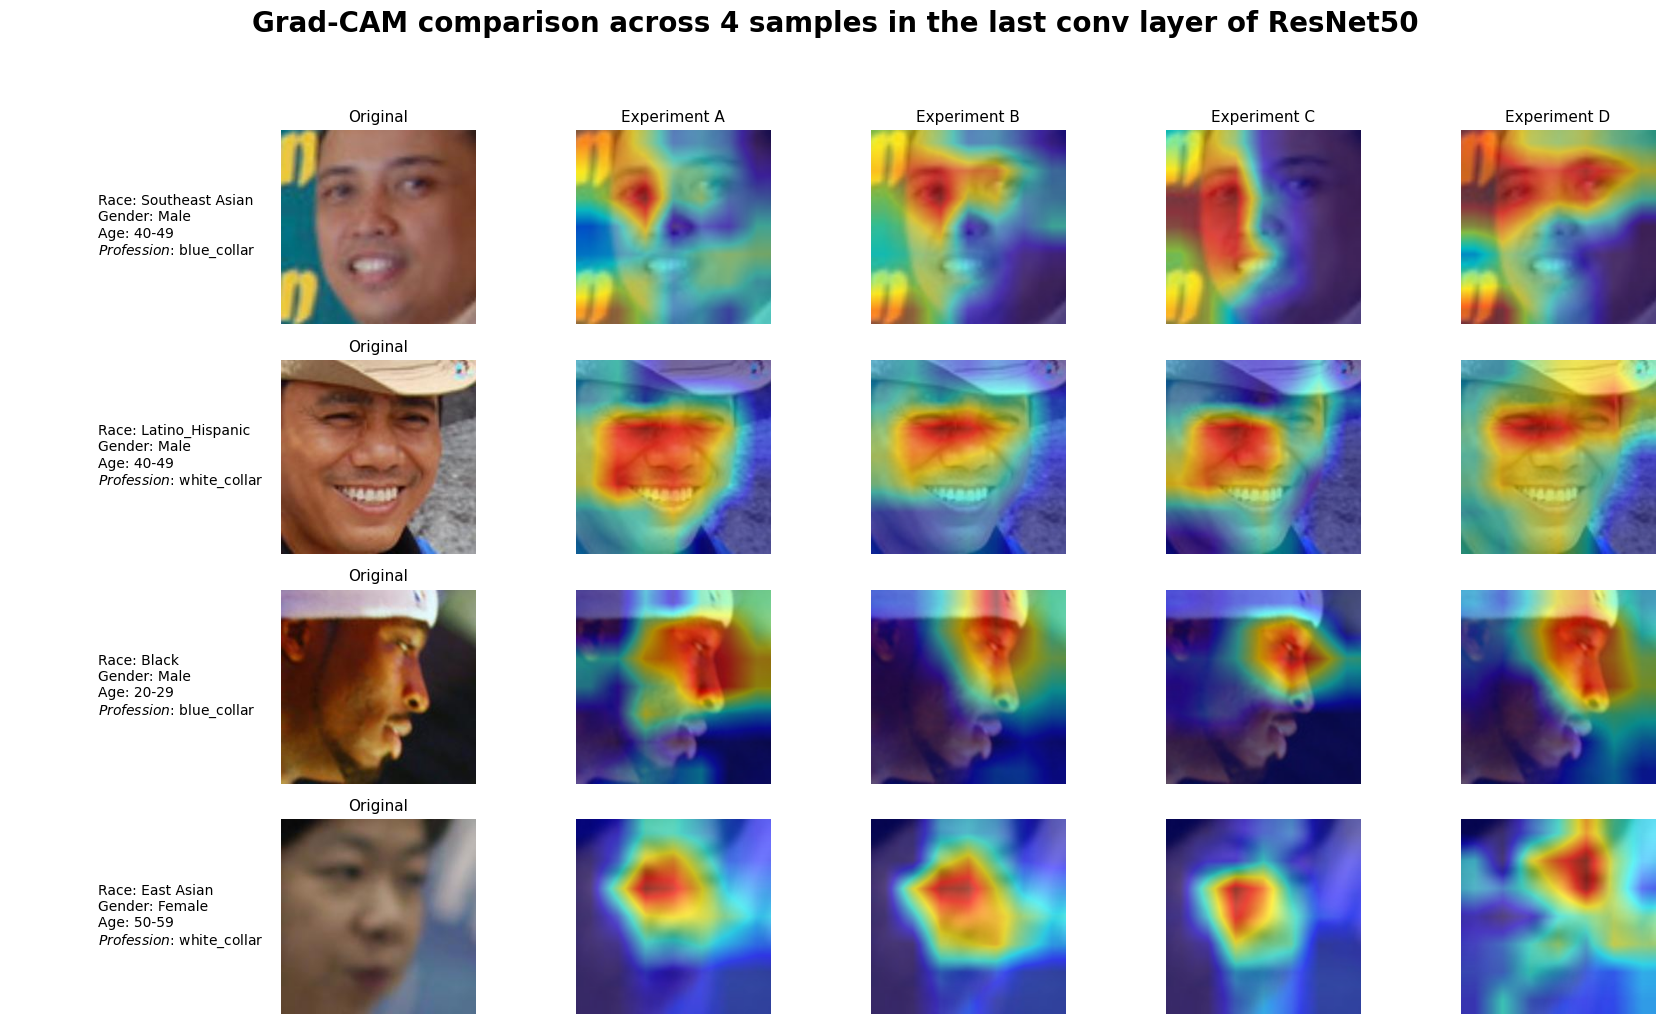

In [39]:
# ----------------------------
# Visualization grid
# ----------------------------
N_COLS = 1 + 1 + len(EXPERIMENTS)  # metadata + original + experiments

fig, axes = plt.subplots(
    nrows=N_SAMPLES,
    ncols=N_COLS,
    figsize=(2.8 * N_COLS, 2.6 * N_SAMPLES),
    gridspec_kw={"width_ratios": [1.2, 1.4] + [1.4] * len(EXPERIMENTS)}
)

if N_SAMPLES == 1:
    axes = np.expand_dims(axes, axis=0)

# ----------------------------
# Grad-CAM loop
# ----------------------------
for i, sample in enumerate(samples):
    img_pil = sample["image"]
    rgb_img = np.array(img_pil.resize((224, 224))).astype(np.float32) / 255.0
    input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

    # ---- Column 0: metadata (text only)
    ax_meta = axes[i, 0]
    ax_meta.axis("off")
    ax_meta.text(
        0.5, 0.5,
        f"Race: {sample['race_str']}\n"
        f"Gender: {sample['gender_str']}\n"
        f"Age: {sample['age_str']}\n"
        r"$\it{Profession}$" + f": {sample['profession']}",
        fontsize=10,
        va="center",
        ha="left"
    )

    # ---- Column 1: original image
    ax_orig = axes[i, 1]
    ax_orig.imshow(rgb_img)
    ax_orig.set_title("Original", fontsize=11)
    ax_orig.axis("off")

    # ---- Grad-CAM columns
    for j, (exp, model) in enumerate(models_dict.items(), start=2):
        ax = axes[i, j]

        cam = GradCAM(
            model=model,
            target_layers=[model.layer4[-1]], # last conv layer in ResNet50
        )

        outputs = model(input_tensor)
        grayscale_cam = cam(
            input_tensor=input_tensor,
            targets=None,
        )[0]

        cam_image = show_cam_on_image(
            rgb_img,
            grayscale_cam,
            use_rgb=True
        )

        ax.imshow(cam_image)
        ax.axis("off")

        if i == 0:
            ax.set_title(
                f"Experiment {exp}",
                fontsize=11,
            )

        del cam  # cleanup

# ----------------------------
# Global title & layout
# ----------------------------
fig.suptitle(
    f"Grad-CAM comparison across {N_SAMPLES} samples in the last conv layer of ResNet50",
    fontsize=20,
    fontweight="bold",
    ha="center"
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### **Observations**

### Experiment A — Fully Balanced but Data-Scarce Regime

Experiment A represents a **controlled baseline**, with perfect balance across **gender, race, and profession**. Quantitatively, this design yields:

* Identical accuracy and balanced accuracy
* Perfect stability in fairness metrics (DP = EO = 0 across epochs)

However, Experiment A also relies on the **smallest training set (9,128 samples)**, which limits the model’s representational capacity.

**Grad-CAM interpretation** reveals that:

* Attention is generally concentrated on **central facial regions** (eyes, nose, mouth)
* Activation maps are **diffuse and low-contrast** compared to other experiments
* The model exhibits **less consistent localization** across samples

This visual behavior is consistent with a model that:

* Has not fully specialized its internal representations
* Relies on generic facial cues rather than highly discriminative features

**Interpretation.**
Strict balancing ensures fairness stability but comes at the cost of **data efficiency**. Even though the model behaves fairly by construction, the Grad-CAM maps suggest **underdeveloped feature hierarchies**, which aligns with the moderate predictive performance. This highlights a critical trade-off: **fairness guarantees do not compensate for insufficient data volume** in deep models.

### Experiment B — Race Imbalance with Increased Data Availability

Experiment B introduces **moderate race imbalance** while keeping the profession label perfectly balanced and significantly increasing the dataset size.

Quantitatively, this experiment achieves:

* The **highest validation accuracy and macro-F1**
* Noticeable **instability in fairness metrics** (DP and EO fluctuations around 0.25)

**Grad-CAM analysis** shows:

* Sharper and more concentrated activations
* Strong focus on **eyes, cheeks, and facial contours**
* Increased consistency across samples compared to Experiment A

However, subtle differences emerge across racial groups:

* Some activations extend beyond facial landmarks into **contextual or background regions**
* Attention patterns vary more strongly between samples

**Interpretation.**
The improved performance is visually supported by **stronger and more confident attention maps**, reflecting better feature learning due to increased data availability. At the same time, the variability in activation patterns suggests that the model may exploit **race-correlated visual cues**, which explains the observed fairness instability.

This experiment demonstrates that **more data improves accuracy**, but when imbalance affects a sensitive attribute, it can also **destabilize fairness behavior**.

### Experiment C — Gender Imbalance with Balanced Target

Experiment C isolates **gender imbalance**, while preserving balance in race and profession and maintaining a relatively large dataset.

Quantitative results show:

* Performance gains over Experiment A
* Fairness instability comparable but slightly less severe than Experiment B

**Grad-CAM observations** indicate:

* Stable attention on core facial regions
* Less background leakage than in Experiment B
* Activation patterns that are more homogeneous across samples

Compared to race imbalance, gender imbalance produces **less dramatic shifts** in attention localization.

**Interpretation.**
The Grad-CAM maps suggest that **gender imbalance affects internal representations differently than race imbalance**. While fairness metrics still fluctuate, the visual evidence indicates a more restrained form of bias amplification. This reinforces the idea that **not all sensitive attributes influence models equally**, and that the **nature of the imbalance matters**, not just its magnitude.

### Experiment D — Naturalistic Setting with Target Imbalance

Experiment D reflects a **real-world observational scenario**, where the profession label follows a natural, highly imbalanced distribution, while race and gender remain balanced.

Quantitatively, this experiment shows:

* Lower raw accuracy
* The **highest balanced accuracy**
* The **largest instability in fairness metrics**

**Grad-CAM visualizations** reveal:

* Highly confident and sharply localized activations
* Strong attention on facial regions that vary systematically across samples
* Greater inter-sample variability in attended features

These patterns suggest that the model has learned **distinct class-specific representations**, including for minority profession classes, which explains the strong balanced accuracy.

However, the variability in attention also indicates that:

* The model is sensitive to naturally occurring correlations between profession and appearance
* Implicit biases emerge even when sensitive attributes are balanced

**Interpretation.**
Large-scale data improves representation learning, but **does not neutralize bias** when the target itself is skewed. Grad-CAM confirms that the model attends confidently to discriminative features, yet these features may encode **structural correlations** present in the data.

### Cross-Experiment Insights from Grad-CAM

Combining quantitative metrics with Grad-CAM interpretability reveals several consistent patterns:

* **Data volume increases attention sharpness and consistency**
* **Strict balancing produces safer but weaker representations due to data scarcity**
* **Sensitive-attribute imbalance alters attention allocation**
* **Target imbalance reshapes feature hierarchies entirely**

Notably:

* Experiment A shows perfect fairness stability (0.0) but visually underdeveloped features
* Experiments B and C show stronger representations but fairness volatility
* Experiment D shows the most confident attention maps alongside the greatest fairness instability

These findings confirm that **fairness is fundamentally a data-centric problem**, not merely a modeling one.

### Summary of Qualitative Findings

* Perfect balance does not guarantee strong performance under data scarcity
* Increased data availability sharpens model attention but may amplify bias
* Race and gender imbalance affect representations differently
* Balanced accuracy is essential in naturally imbalanced settings
* Grad-CAM generally reveals biases that are not fully captured by aggregate metrics

**Overall conclusion.**
There is no universally optimal dataset design. Fairness–performance trade-offs must be managed explicitly, and **interpretability tools such as Grad-CAM are essential** for understanding *how* and *why* models behave differently under controlled and realistic data regimes.

### **Quantitative Analysis**

In this section we would compare visually the obtained results for each experiment.

In [9]:
def annotate_bars(ax, values, fmt="{:.3f}", pct=False):
    max_val = max(values)

    for p, v in zip(ax.patches, values):
        if v == 0:
            continue

        label = fmt.format(v)
        if pct:
            label += f"\n({v * 100:.1f}%)"

        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            label,
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold"
        )

    ax.set_ylim(0, max_val * 1.15)


In [ ]:
CHECKPOINT_DIR = "./checkpoints"

EXPERIMENTS = {
    "A": "A_resnet50_best.pth",
    "B": "B_resnet50_best.pth",
    "C": "C_resnet50_best.pth",
    "D": "D_resnet50_best.pth",
}

def load_experiment_metrics(checkpoint_dir, experiments):
    results = {}

    for exp, fname in experiments.items():
        path = os.path.join(checkpoint_dir, fname)
        ckpt = torch.load(path, map_location="cpu")

        results[exp] = {
            "val_acc": ckpt.get("val_acc", None),
            "val_bal_acc": ckpt.get("val_bal_acc", None),
            "val_f1": ckpt.get("val_f1", None),
        }

    return results

results = load_experiment_metrics(CHECKPOINT_DIR, EXPERIMENTS)

# Inject reported validation metrics
results["A"].update({"val_bal_acc": 0.4018, "val_f1": 0.3718})
results["B"].update({"val_bal_acc": 0.4129, "val_f1": 0.3968})
results["C"].update({"val_bal_acc": 0.4036, "val_f1": 0.3740})
results["D"].update({"val_bal_acc": 0.4271, "val_f1": 0.3707})

**Figure 1 — Validation Accuracy vs Balanced Accuracy**

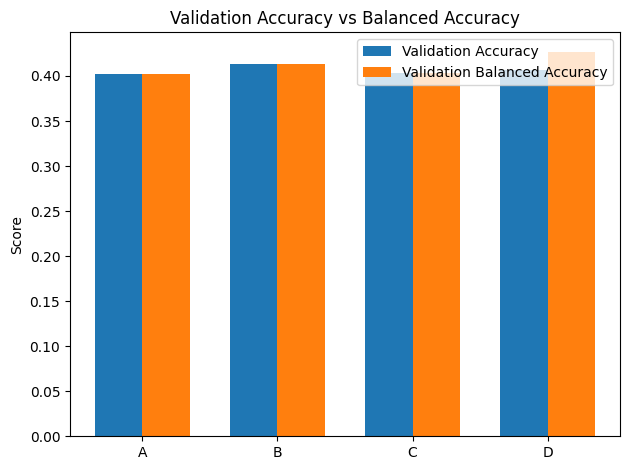

In [14]:
labels = list(results.keys())
val_acc = [results[k]["val_acc"] for k in labels]
val_bal_acc = [results[k]["val_bal_acc"] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, val_acc, width, label="Validation Accuracy")
plt.bar(x + width/2, val_bal_acc, width, label="Validation Balanced Accuracy")
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Validation Accuracy vs Balanced Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


**What this shows**

* A/B/C: overlapping bars

* D: separation → target imbalance effect

**Figure 2 — Accuracy–Balanced Accuracy Gap**

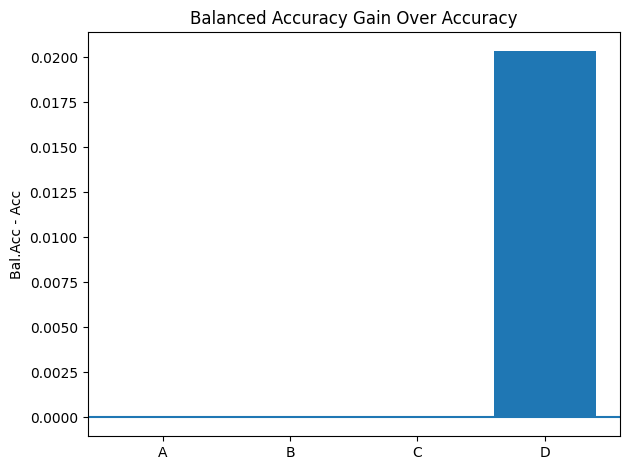

In [16]:
gap = [results[k]["val_bal_acc"] - results[k]["val_acc"] for k in labels]

plt.figure()
plt.bar(labels, gap)
plt.axhline(0)
plt.ylabel("Bal.Acc - Acc")
plt.title("Balanced Accuracy Gain Over Accuracy")
plt.tight_layout()
plt.show()


**Interpretation**

* Zero for A/B/C

* Positive gap for D -> imbalance in target, similar to figure 1.

**Figure 3 — Validation F1 Comparison**

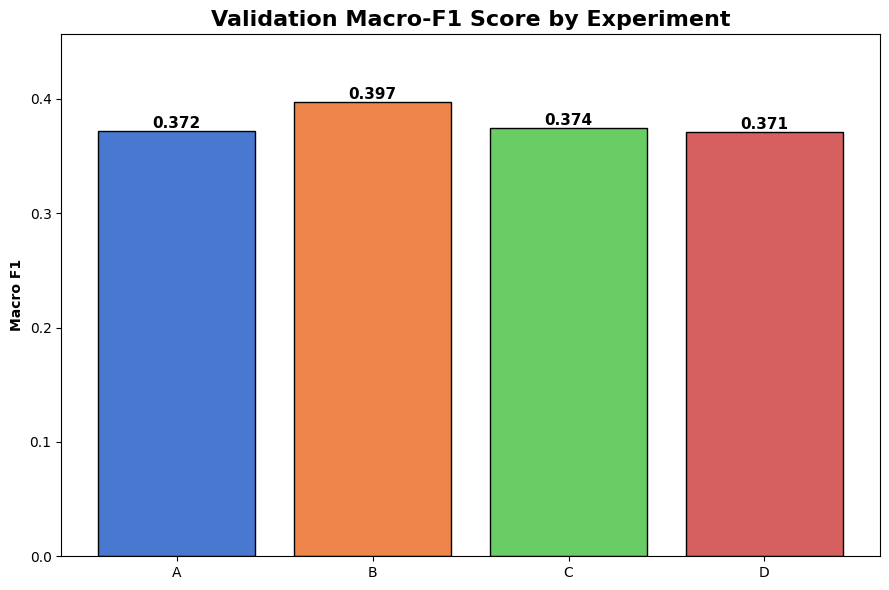

In [17]:
val_f1 = [results[k]["val_f1"] for k in labels]

plt.figure(figsize=(9, 6))
ax = plt.gca()

bars = ax.bar(
    labels,
    val_f1,
    color=sns.color_palette("muted"),
    edgecolor="black"
)

ax.set_ylabel("Macro F1", fontweight="heavy")
ax.set_title(
    "Validation Macro-F1 Score by Experiment",
    fontsize=16,
    fontweight="bold"
)

annotate_bars(ax, val_f1)

plt.tight_layout()
plt.show()


**Why this matters**

* Shows class-level robustness

* Confirms that higher Acc ≠ better per-class performance

#### **What These Figures Prove (Methodologically)**

| Figure             | Demonstrates               |
| ------------------ | -------------------------- |
| Acc vs Bal.Acc     | Effect of target imbalance |
| Bal.Acc gap        | Need for balanced metrics  |
| F1                 | Class-level robustness     |


## 7. Objective Analysis

This section provides an objective, metric-based interpretation of the experimental results. The goal is to analyze performance and fairness outcomes using quantitative evidence, without introducing normative or ethical judgments.

### Accuracy and Balanced Accuracy

Across experiments, differences between accuracy and balanced accuracy reveal the impact of dataset imbalance on model evaluation.

- In Experiment A, accuracy and balanced accuracy are identical, confirming the absence of class imbalance.
- In Experiments B and C, the two metrics remain identical, indicating that target balance mitigates distortion despite sensitive attribute imbalance.
- In Experiment D, a clear gap emerges: validation accuracy (0.4067) is substantially lower than balanced accuracy (0.4271).

This gap indicates that standard accuracy underestimates performance on minority profession classes, reinforcing the need for balanced metrics in realistic, imbalanced settings.

### F1-score Comparison

The macro-F1 score provides insight into class-level robustness by weighting all classes equally.

- Experiment B achieves the highest macro-F1 (0.3968), reflecting strong overall class discrimination enabled by increased data availability.
- Experiments A and D show lower F1 scores despite fairness stability (A) or higher balanced accuracy (D), suggesting that neither fairness by construction nor realism alone guarantees robust class-wise performance.
- Experiment C occupies an intermediate position, indicating that gender imbalance impacts F1 less severely than race imbalance.

Overall, macro-F1 correlates more strongly with data volume than with fairness stability.

### Fairness Metric Stability

Fairness stability is evaluated through the behavior of Demographic Parity (DP) and Equal Opportunity (EO) over training epochs.

- Experiment A maintains DP = EO = 0 throughout training, demonstrating perfect fairness stability under strict balancing.
- Experiments B, C (moderate around 0.25), and D (high around 0.5) exhibit fluctuating DP and EO values, indicating sensitivity to data composition and implicit correlations.
- No experiment with increased data volume achieves fairness stability comparable to Experiment A.

Quantitatively, this suggests that fairness stability is inversely related to dataset size under the current training regime.

### Cross-Experiment Metric Comparison

A comparative analysis of all experiments reveals the following quantitative patterns:

- Highest validation accuracy and F1-score: Experiment B
- Highest balanced accuracy: Experiment D
- Highest fairness stability: Experiment A
- Strongest accuracy–balanced accuracy divergence: Experiment D

These results indicate that no single experiment dominates across all evaluation dimensions.

**Overall**, the quantitative analysis confirms that improvements in predictive performance, class balance, and fairness stability cannot be simultaneously maximized under the current experimental constraints.

## 8. Critical Analysis

### Were the Expectations of the Adaptation Met?

The primary expectation of the dataset adaptations was to improve fairness without severely degrading predictive performance.

- Strict balancing (Experiment A) successfully achieved fairness stability but failed to deliver competitive performance due to data scarcity.
- Partial imbalance (Experiments B and C) improved performance but introduced fairness instability.
- The naturalistic setting (Experiment D) improved balanced accuracy but did not resolve fairness concerns.

Therefore, the adaptation strategies only partially met their intended objectives.

### Limitations of the Study

Several limitations constrain the generalizability of these findings:

- Limited dataset size in all experiments but primarily in the fully balanced scenario (experiment A)
- Single backbone architecture (ResNet-50)
- Absence of fairness-aware loss functions or constraints
- Evaluation restricted to DP and EO metrics
- Single training run per experiment (no variance estimation)

These limitations suggest that observed trends should be interpreted as indicative rather than definitive.

### Trade-offs and Identified Conflicts

The experiments reveal consistent trade-offs:

- Fairness stability vs. data availability
- Realism vs. metric interpretability
- Accuracy vs. minority-class performance

These conflicts indicate that fairness-aware modeling requires explicit prioritization of objectives rather than implicit assumptions.

## 9. Reflection

### Ethical and Equity Implications

The observed instability in fairness metrics under realistic data conditions highlights the risk of deploying models that appear accurate but systematically disadvantage specific demographic groups.

This is particularly critical in profession-related classification tasks, which may influence access to economic opportunities.

### Regulatory Context

Under emerging regulatory frameworks such as the EU AI Act, systems that impact employment-related decisions are classified as high-risk and require explicit bias assessment and mitigation.

The results of this study demonstrate that post hoc evaluation alone is insufficient to guarantee compliance.

### Practical Recommendations

Based on the findings, the following recommendations are proposed:

- Use balanced accuracy and macro-F1 as default evaluation metrics
- Avoid relying solely on dataset balancing to ensure fairness
- Incorporate fairness-aware training objectives
- Report fairness metric variance across training runs

## 10. Conclusions

* This study demonstrates that **dataset design is a primary determinant** of both predictive performance and fairness behavior in deep learning systems, often outweighing architectural or optimization choices when these are held constant. Through a controlled comparison of four dataset adaptation strategies, the results show that **fairness, performance, and realism cannot be simultaneously optimized by data balancing alone**.

* The fully balanced setting (Experiment A) confirms that fairness stability can be achieved through strict control of data distributions. However, the associated **reduction in data volume** limits representation learning, leading to weaker generalization and underdeveloped feature hierarchies, as evidenced by both quantitative metrics and Grad-CAM visualizations. This finding underscores that **fairness by construction is not cost-free**, particularly in data-hungry deep models.

* Partial imbalance scenarios (Experiments B and C) illustrate that increasing data availability can significantly improve predictive performance, yet at the expense of **fairness robustness**. The observed fluctuations in Demographic Parity and Equal Opportunity—together with more variable attention patterns—demonstrate that imbalance in sensitive attributes can subtly shape learned representations, even when the prediction target is perfectly balanced. Importantly, the differing effects of race and gender imbalance indicate that **sensitive attributes are not interchangeable**, and that fairness interventions must be attribute-specific rather than generic.

* The naturalistic setting (Experiment D) provides critical insight into real-world deployments. While this experiment achieves the highest balanced accuracy and exhibits strong, confident feature localization, it also exposes the **structural limitations of post hoc fairness evaluation**. When the target variable itself is imbalanced, fairness instability persists despite large-scale data and balanced sensitive attributes. This highlights that **realism amplifies latent societal biases rather than neutralizing them**, and that standard performance metrics can obscure inequities affecting minority groups.

* Across all experiments, Grad-CAM interpretability plays a crucial complementary role, revealing differences in **feature reliance, attention sharpness, and representational consistency** that are not fully captured by aggregate metrics. These qualitative insights reinforce the conclusion that **fairness is not solely a numerical property of model outputs**, but also a property of the internal representations learned from data.

* **Overall**, the findings suggest that fairness-aware machine learning requires a **data-centric and multi-objective approach**, where dataset design, evaluation metrics, interpretability, and regulatory constraints are considered jointly. There is no universally optimal adaptation strategy; instead, practitioners must explicitly decide which trade-offs are acceptable in a given application context.

* In high-stakes domains such as profession-related classification, these decisions carry ethical and regulatory significance. Consequently, fairness should be treated not as a post-training diagnostic, but as a **core design principle**, integrated throughout the data collection, modeling, and evaluation pipeline.

## 11. References

* Hardt, M., Price, E., & Srebro, N. (2016). *Equality of Opportunity in Supervised Learning*. Advances in Neural Information Processing Systems (NeurIPS).

* Barocas, S., Hardt, M., & Narayanan, A. (2023). *Fairness and Machine Learning: Limitations and Opportunities*. MIT Press.

* European Union. (2024). *Proposal for a Regulation Laying Down Harmonised Rules on Artificial Intelligence (Artificial Intelligence Act)*.

* He, K., Zhang, X., Ren, S., & Sun, J. (2016). *Deep Residual Learning for Image Recognition*. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR).

### Dataset Bias, Representation, and Fairness

* Suresh, H., & Guttag, J. (2021). *A Framework for Understanding Sources of Harm throughout the Machine Learning Life Cycle*. ACM Conference on Equity and Access in Algorithms, Mechanisms, and Optimization (EAAMO).

* Mehrabi, N., Morstatter, F., Saxena, N., Lerman, K., & Galstyan, A. (2021). *A Survey on Bias and Fairness in Machine Learning*. ACM Computing Surveys.

* Kleinberg, J., Mullainathan, S., & Raghavan, M. (2017). *Inherent Trade-Offs in the Fair Determination of Risk Scores*. Proceedings of Innovations in Theoretical Computer Science (ITCS).

* Buolamwini, J., & Gebru, T. (2018). *Gender Shades: Intersectional Accuracy Disparities in Commercial Gender Classification*. Proceedings of the Conference on Fairness, Accountability, and Transparency (FAT*).

### Imbalanced Learning and Evaluation Metrics

* He, H., & Garcia, E. A. (2009). *Learning from Imbalanced Data*. IEEE Transactions on Knowledge and Data Engineering.

* Japkowicz, N., & Stephen, S. (2002). *The Class Imbalance Problem: A Systematic Study*. Intelligent Data Analysis.

* Brodersen, K. H., Ong, C. S., Stephan, K. E., & Buhmann, J. M. (2010). *The Balanced Accuracy and Its Posterior Distribution*. International Conference on Pattern Recognition (ICPR).

### Explainability and Interpretability in Deep Learning

* Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2017). *Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization*. Proceedings of the IEEE International Conference on Computer Vision (ICCV).

* Adebayo, J., Gilmer, J., Muelly, M., Goodfellow, I., Hardt, M., & Kim, B. (2018). *Sanity Checks for Saliency Maps*. NeurIPS.

* Samek, W., Montavon, G., Vedaldi, A., Hansen, L. K., & Müller, K.-R. (2017). *Explainable Artificial Intelligence: Interpreting, Explaining and Visualizing Deep Learning*. Springer.

* Doshi-Velez, F., & Kim, B. (2017). *Towards a Rigorous Science of Interpretable Machine Learning*. arXiv preprint arXiv:1702.08608.

### Fairness, Interpretability, and Regulation

* Raji, I. D., Smart, A., White, R. N., et al. (2020). *Closing the AI Accountability Gap: Defining an End-to-End Framework for Internal Algorithmic Auditing*. Proceedings of the ACM Conference on Fairness, Accountability, and Transparency.

* Selbst, A. D., Boyd, D., Friedler, S. A., Venkatasubramanian, S., & Vertesi, J. (2019). *Fairness and Abstraction in Sociotechnical Systems*. Proceedings of the Conference on Fairness, Accountability, and Transparency.

* Rudin, C. (2019). *Stop Explaining Black Box Machine Learning Models for High Stakes Decisions and Use Interpretable Models Instead*. Nature Machine Intelligence.